In [1]:
import math
import scipy as sp
import numpy as np

# Data Handling
import pandas as pd

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
sns.set()
plt.style.use("fivethirtyeight")
# Machine learning and statistical libraries
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#dataframe index manipulations
import datetime

In [2]:
# Import data
df = pd.read_csv("data2022_train.csv", index_col=0, parse_dates=True)

In [4]:
november = df.loc[df.index.month == 11]

In [5]:
november

y
2017-11-01 00:00:00  27089.23077
2017-11-01 00:10:00  26701.53846
2017-11-01 00:20:00  26375.38462
2017-11-01 00:30:00  25963.07692
2017-11-01 00:40:00  25593.84615
...                          ...
2017-11-30 23:10:00  31347.69231
2017-11-30 23:20:00  30603.07692
2017-11-30 23:30:00  29889.23077
2017-11-30 23:40:00  29249.23077
2017-11-30 23:50:00  28584.61538

[4320 rows x 1 columns]

In [28]:
# Add December to the dataframe
# New df, with december 2017 as index
df_dec = pd.DataFrame(index=pd.date_range(start='2017-12-1', end='2018-1-1', freq='10T'), columns=["y"])
df_dec = df_dec[:-1]

# Concatenate the two dataframes
df = pd.concat([df, df_dec])

In [29]:
# Creare un indice temporale per la nuova riga
new_index = pd.to_datetime("2018-01-01 00:00:00")
# Creare una nuova riga con l'indice temporale
new_row = pd.DataFrame(index=[new_index], columns=["y"])


In [30]:
df = pd.concat([df, new_row])

In [31]:
df

y
2017-01-01 00:00:00  34055.69620
2017-01-01 00:10:00  29814.68354
2017-01-01 00:20:00  29128.10127
2017-01-01 00:30:00  28228.86076
2017-01-01 00:40:00  27335.69620
...                          ...
2017-12-31 23:20:00          NaN
2017-12-31 23:30:00          NaN
2017-12-31 23:40:00          NaN
2017-12-31 23:50:00          NaN
2018-01-01 00:00:00          NaN

[52561 rows x 1 columns]

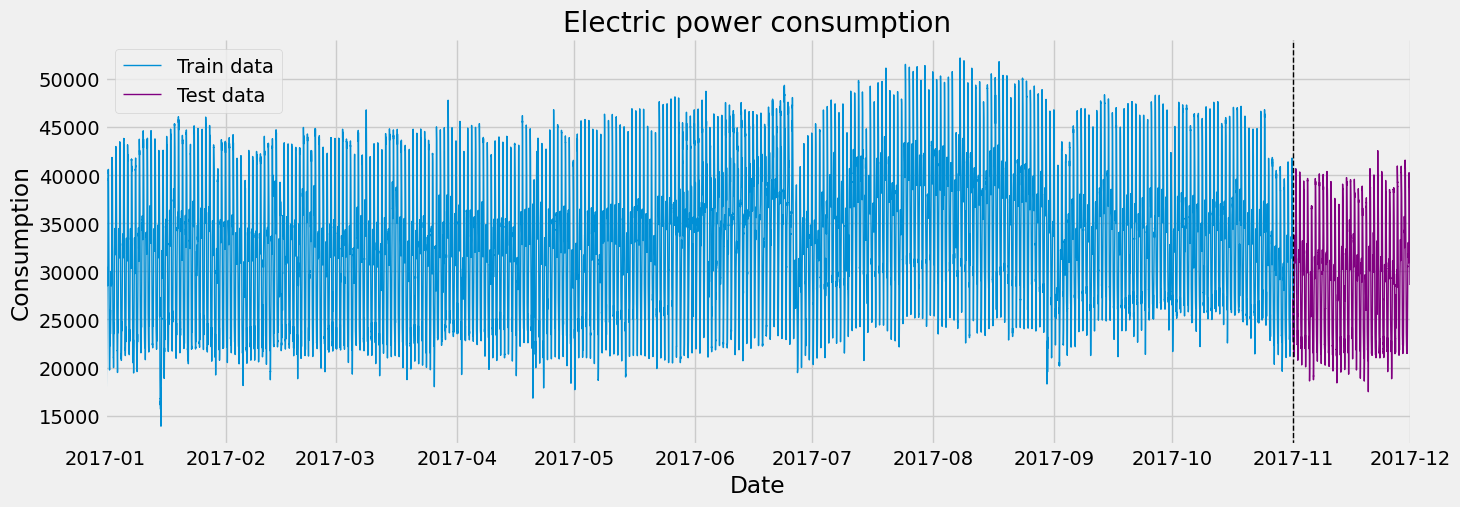

In [167]:
# Plot time series
plt.figure(figsize=(15,5))
plt.plot(df.loc[:'2017-11-1']['y'], label="Train data",lw=1)
plt.plot(df.loc['2017-11-1':]['y'], label='Test data',lw=1, color='purple')
plt.title('Electric power consumption')
plt.ylabel('Consumption')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.xlim(pd.to_datetime("2017-1-1"), pd.to_datetime("2017-12-1"))
# Remove top and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Add line on split between train and test data
plt.axvline(x=pd.to_datetime("2017-11-1"), color='black', linestyle='--', lw=1)
plt.savefig('timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# Add a column with the day of the week
df['Day'] = df.index.dayofweek

# Translate day of the week to Italian
df['Day'] = df['Day'].replace({0:'Lunedì', 1:'Martedì', 2:'Mercoledì', 3:'Giovedì', 4:'Venerdì', 5:'Sabato', 6:'Domenica'})

In [34]:
# Translate day of the week to Italian
df['Day'] = df['Day'].replace({0:'Lunedì', 1:'Martedì', 2:'Mercoledì', 3:'Giovedì', 4:'Venerdì', 5:'Sabato', 6:'Domenica'})

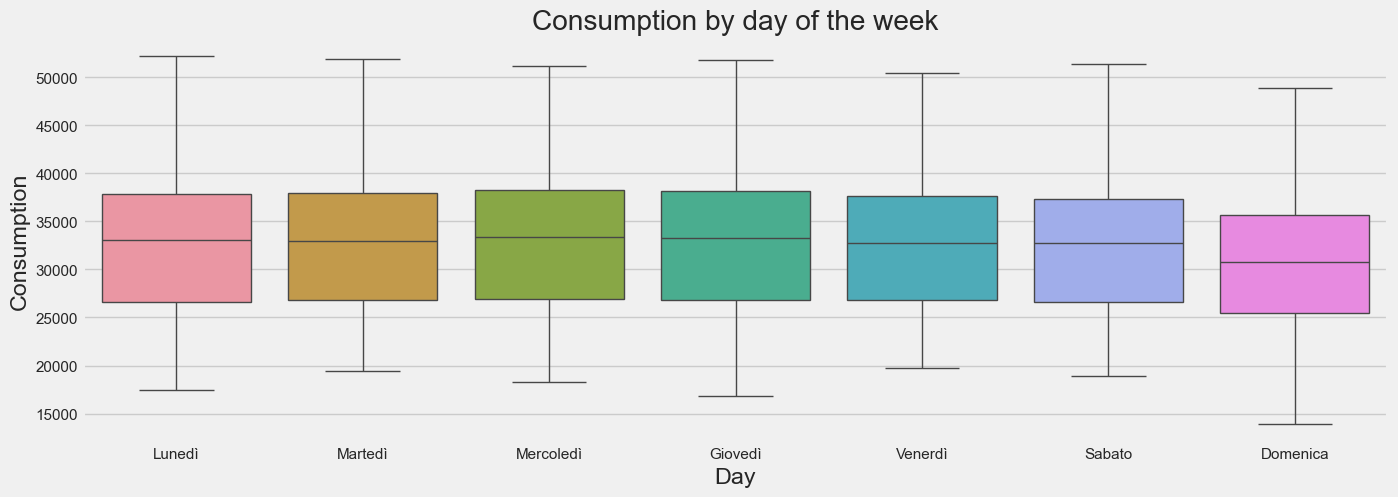

In [35]:
# Boxplot day of the week and distribution of consumption
plt.figure(figsize=(15,5))
sns.boxplot(x='Day', y='y', data=df, order=['Lunedì', 'Martedì', 'Mercoledì', 'Giovedì', 'Venerdì', 'Sabato', 'Domenica'], linewidth=1)
plt.title('Consumption by day of the week')
plt.ylabel('Consumption')
plt.show()

Vediamo un calo la domenica, quindi possiamo dedurre ci sia stagionalità settimanale

Text(0.5, 1.0, 'Consumption by hour of the day')

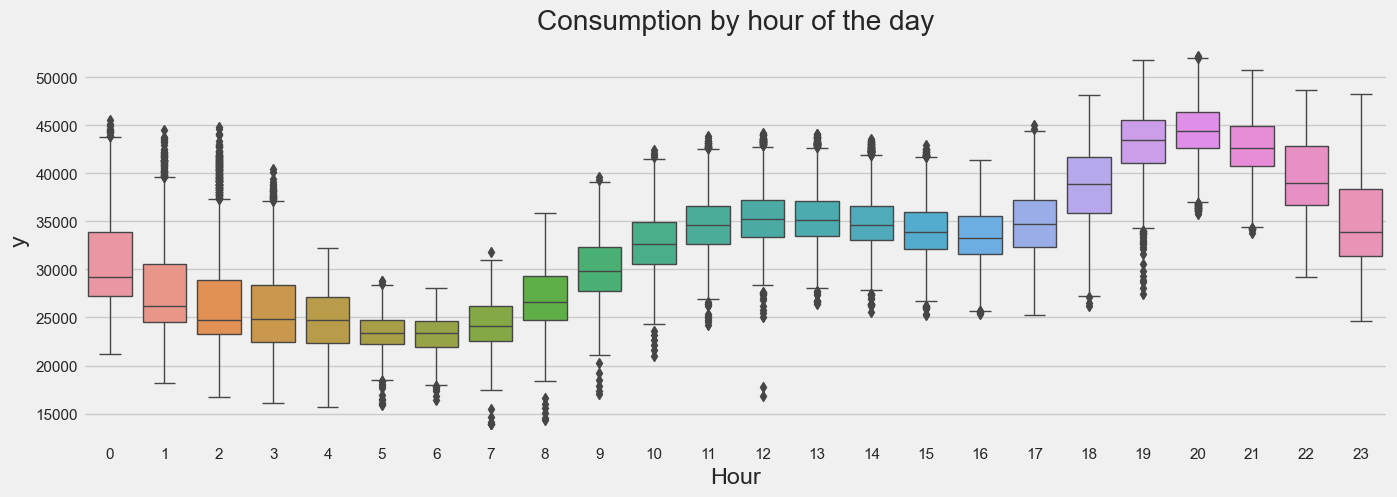

In [36]:
# Add a column with the hour of the day
df['Hour'] = df.index.hour

# Boxplot hour of the day and distribution of consumption
plt.figure(figsize=(15,5))
sns.boxplot(x='Hour', y='y', data=df, linewidth=1)
plt.title('Consumption by hour of the day')

Vediamo una stagionalità oraria, com'era prevedibile. 

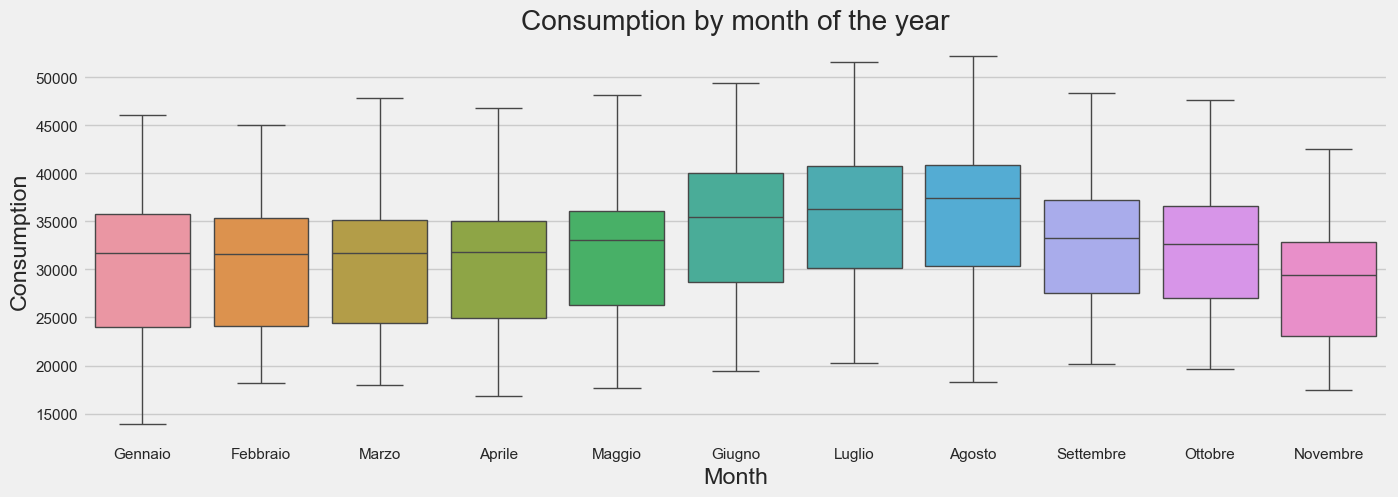

In [37]:
# Add a column with the month of the year
df['Month'] = df.index.month

# Translate month of the year to Italian
df['Month'] = df['Month'].replace({1:'Gennaio', 2:'Febbraio', 3:'Marzo', 4:'Aprile', 5:'Maggio', 6:'Giugno',
                                   7:'Luglio', 8:'Agosto', 9:'Settembre', 10:'Ottobre', 11:'Novembre'})

# Boxplot month of the year and distribution of consumption
plt.figure(figsize=(15,5))
sns.boxplot(x='Month', y='y', data=df, order=['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 'Agosto', 'Settembre', 'Ottobre', 'Novembre'], linewidth=1)
plt.title('Consumption by month of the year')
plt.ylabel('Consumption')
plt.show()

Vediamo come in estate il consumo elettrico aumenta, probabilmente dovuto all'utilizzo di condizionatori, come si dimostra anche dal ripido calo da Agosto a Settembre.

Facciamo che non includiamo la stagionalità annuale, in quanto non possediamo dati per un anno intero, e tratteremo quindi la stagionalità annua come un trend.

C:\Users\matte\AppData\Local\Temp\ipykernel_15740\769912306.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(212)


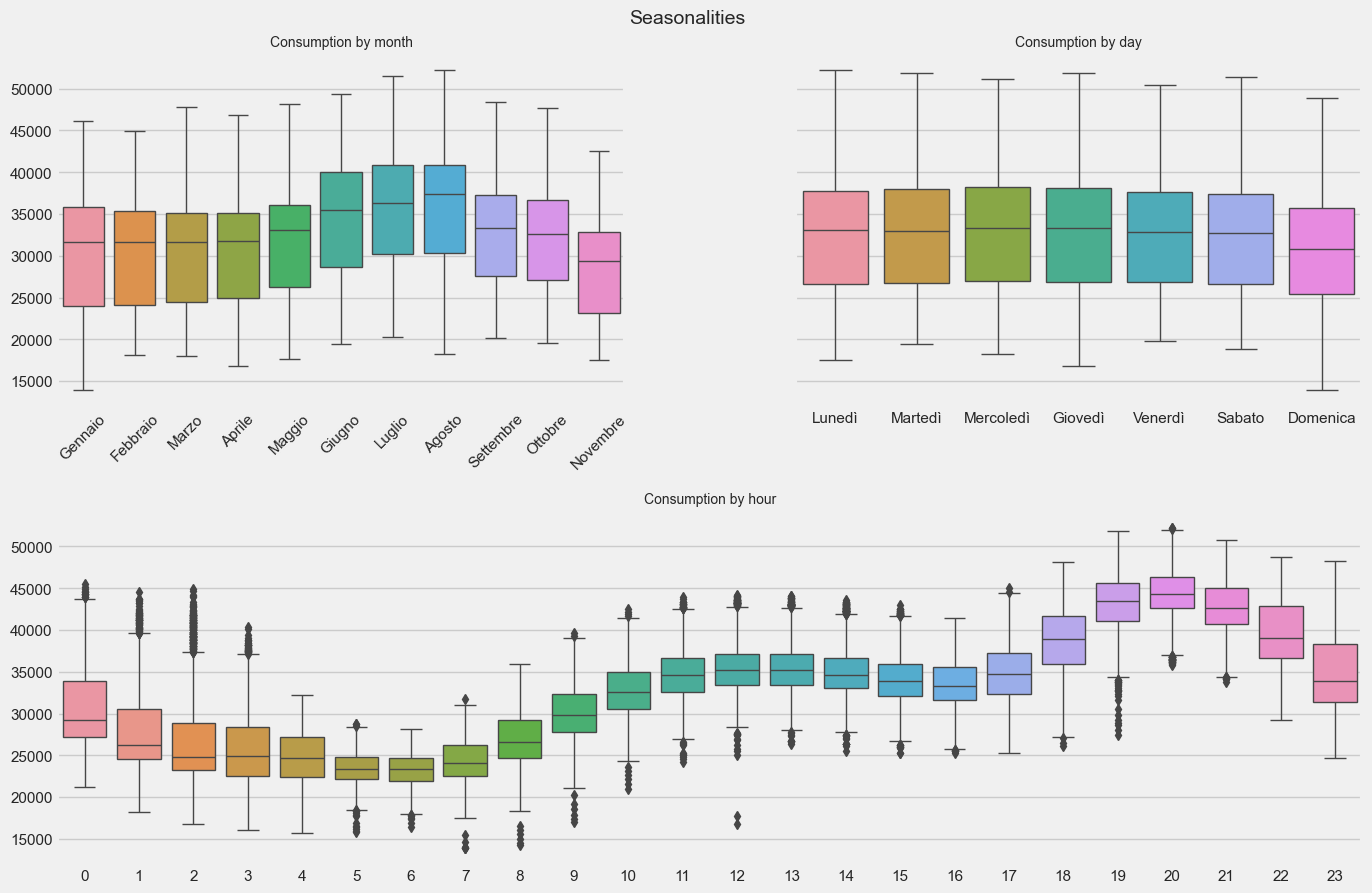

In [38]:
# Produce only one plot containing the three subplots, divided in 2 rows and 2 columns,
# first two plots are for day of the week and hour of the day, last plot is for month of the year and is 2 plots wide
fig, ((ax1, ax2), ax3) = plt.subplots(2, 2, figsize=(15,10), sharey=True)

ax1 = plt.subplot(222)
ax2 = plt.subplot(212)
ax3 = plt.subplot(221)
# Add title to the whole figure
fig.suptitle('Seasonalities', fontsize=14, y=0.925)
# Rotate x axis labels
plt.setp(ax3.get_xticklabels(), rotation=45)
# Plot day of the week and hour of the day, add title to each subplot
sns.boxplot(x='Day', y='y', data=df, order=['Lunedì', 'Martedì', 'Mercoledì', 'Giovedì', 'Venerdì', 'Sabato', 'Domenica'], ax=ax1, linewidth=1)
ax1.set_title('Consumption by day', fontdict={'fontsize': 10})
sns.boxplot(x='Hour', y='y', data=df, ax=ax2, linewidth=1)
ax2.set_title('Consumption by hour', fontdict={'fontsize': 10})
# Add margin between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
# Plot month of the year
sns.boxplot(x='Month', y='y', data=df, order=['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 'Agosto', 'Settembre', 'Ottobre', 'Novembre'], ax=ax3, linewidth=1)
ax3.set_title('Consumption by month', fontdict={'fontsize': 10})
# In ax2 and ax3, remove x axis label
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
# Background color of the whole figure is white
plt.savefig('seasonalities.png', dpi=300, bbox_inches='tight')
plt.show()


In [39]:
# Per ogni ora, prendi la y al minuto :00, senza fare la media
df_sample = df

In [40]:
train = df_sample.loc[:'2017-11-1'].resample('H').first()
test = df_sample.loc['2017-11-1':"2017-11-30"].resample('H').first()

c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


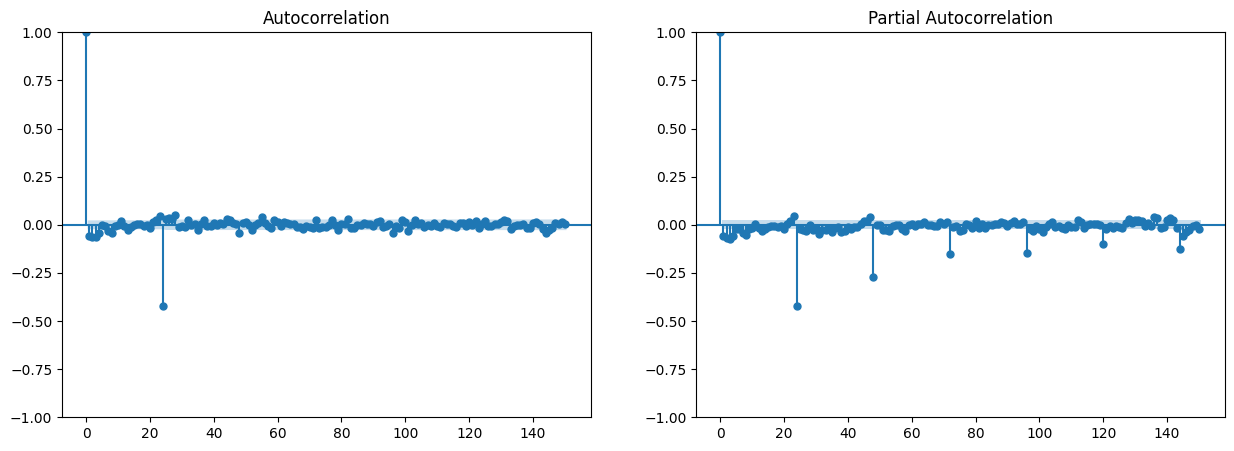

In [64]:
# ACF and PACF plots
plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plot_acf(train['y'].diff(24).diff(1).dropna(), lags=150, ax=ax1),
plot_pacf(train['y'].diff(24).diff(1).dropna(), lags=150, ax=ax2),

plt.savefig('acf_pacf.png', dpi=300, bbox_inches='tight')


In [18]:
submission_train_00 = df_sample.loc[:'2017-11-1'].resample('30T').first()

# Split the training set in two parts, one containing minute 00 and one containing minute 30
submission_train_30 = submission_train_00.loc[submission_train_00.index.minute == 30]
submission_train_00 = submission_train_00.loc[submission_train_00.index.minute == 0]

## No exogenous variables

In [66]:
# Sarimax model definition, stagionalità 24 ore, MA(1)
model_a = sm.tsa.statespace.SARIMAX(train['y'], order=(1,1,1), seasonal_order=(0,1,1,24))
results_a = model_a.fit()
print(results_a.summary())

c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 7320
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -59714.353
Date:                            Sun, 29 Jan 2023   AIC                         119436.706
Time:                                    20:28:33   BIC                         119464.286
Sample:                                01-01-2017   HQIC                        119446.190
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8786      0.003    260.037      0.000       0.872       0.885
ma.L1         -1.0000      0.042   

NameError: name 'results_a' is not defined

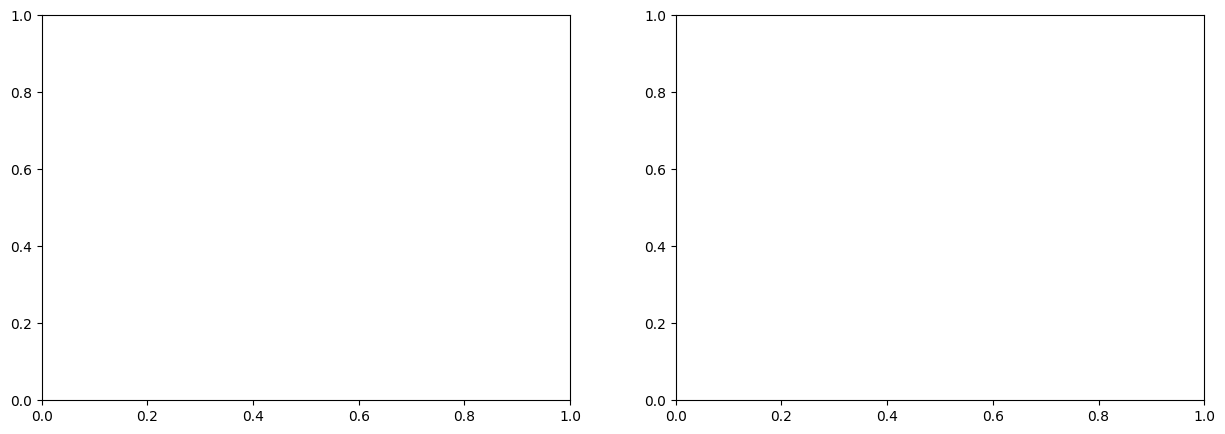

In [65]:
# Plot the acf and pacf of the residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plot_acf(results_a.resid, lags=150, ax=ax1),
plot_pacf(results_a.resid, lags=150, ax=ax2),

fig.savefig('acf_pacf_resid.png', dpi=300, bbox_inches='tight')

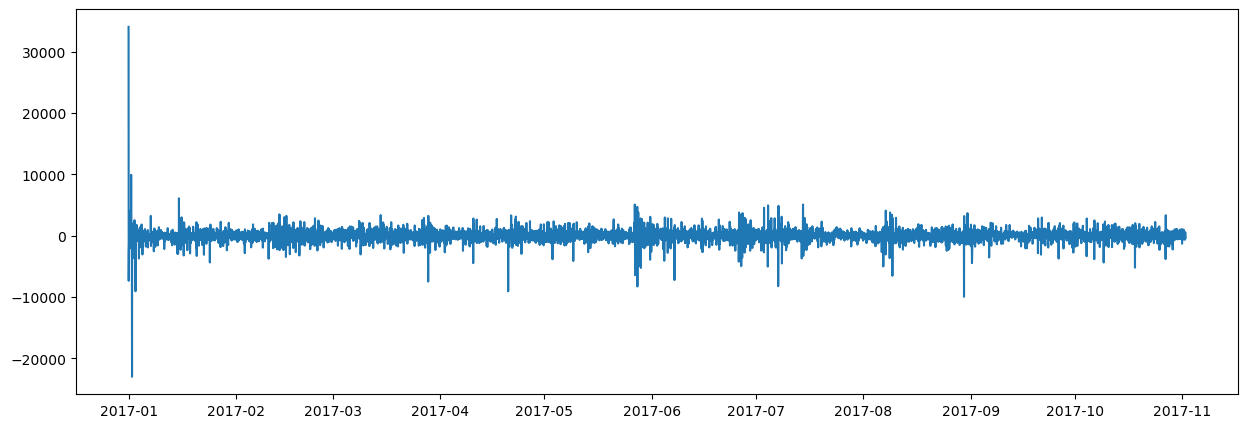

In [243]:
# Plot residuals
plt.figure(figsize=(15,5))
plt.plot(results_a.resid)

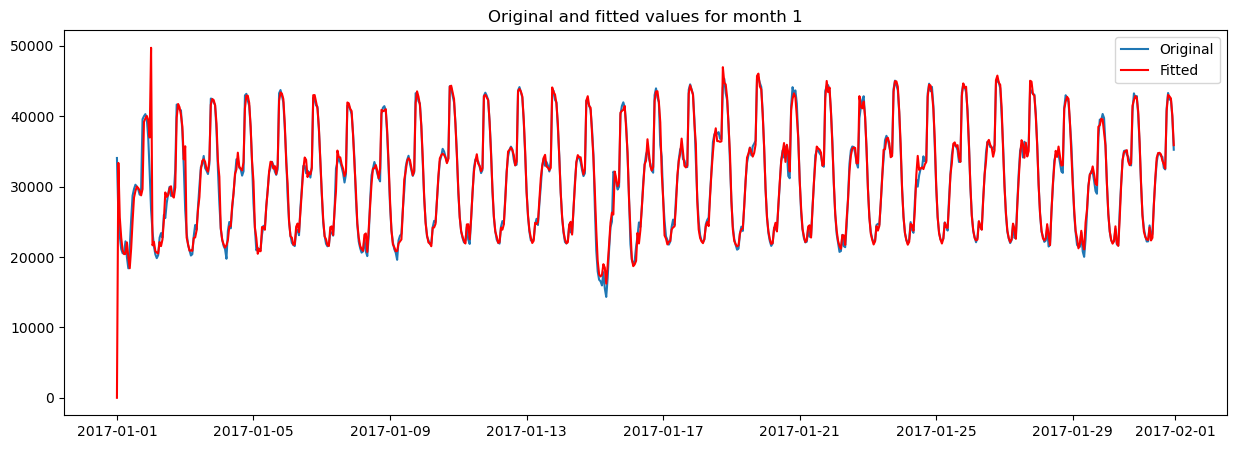

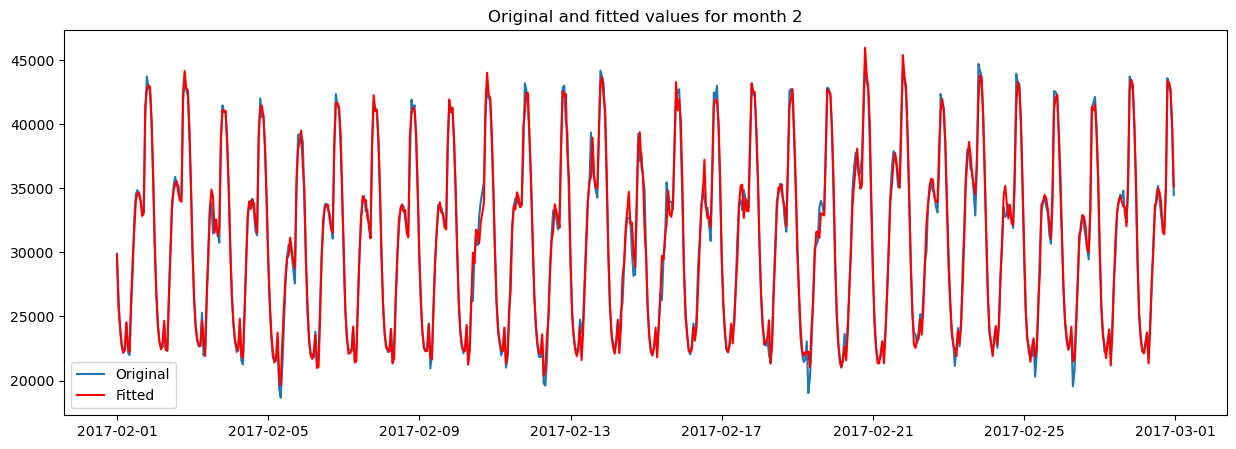

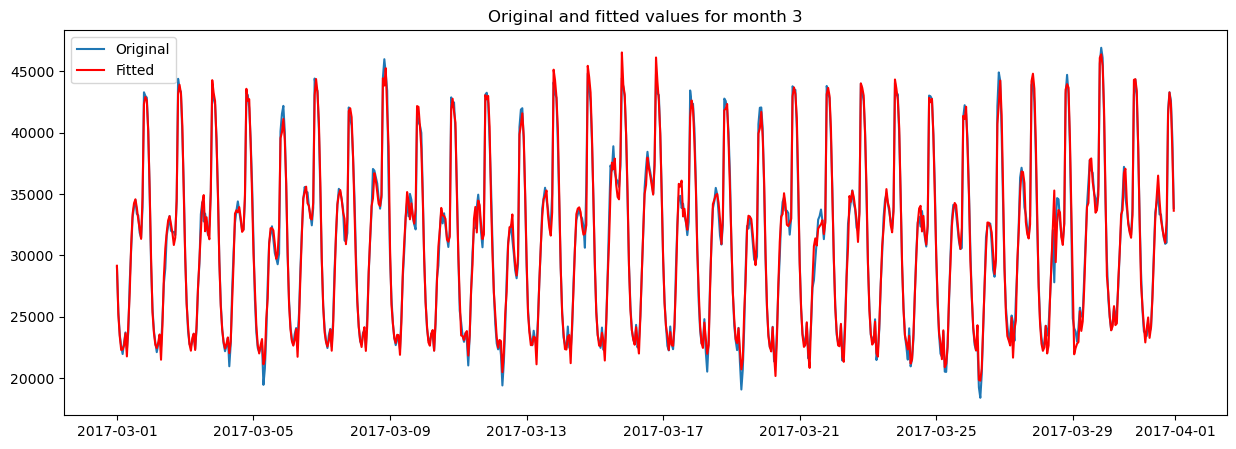

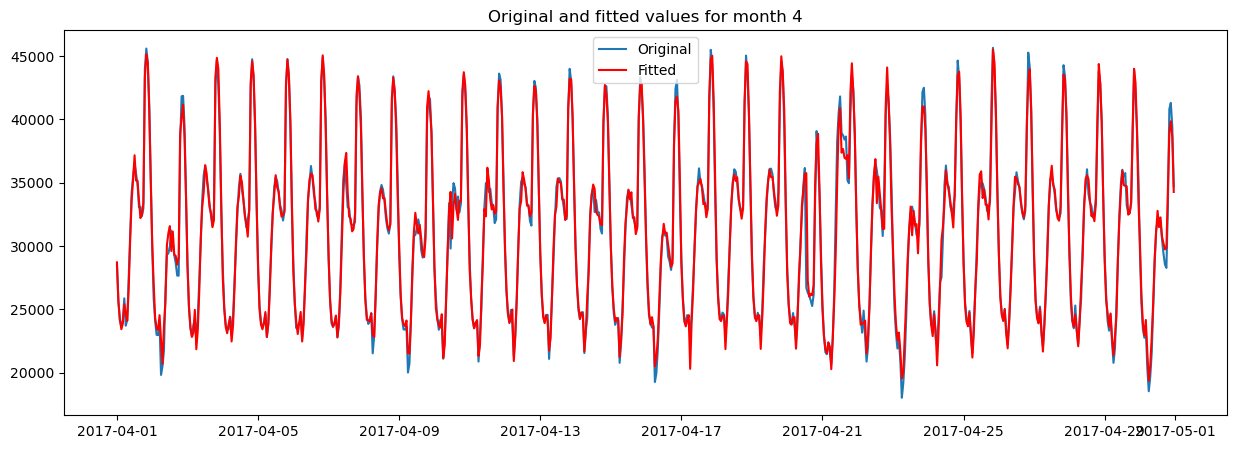

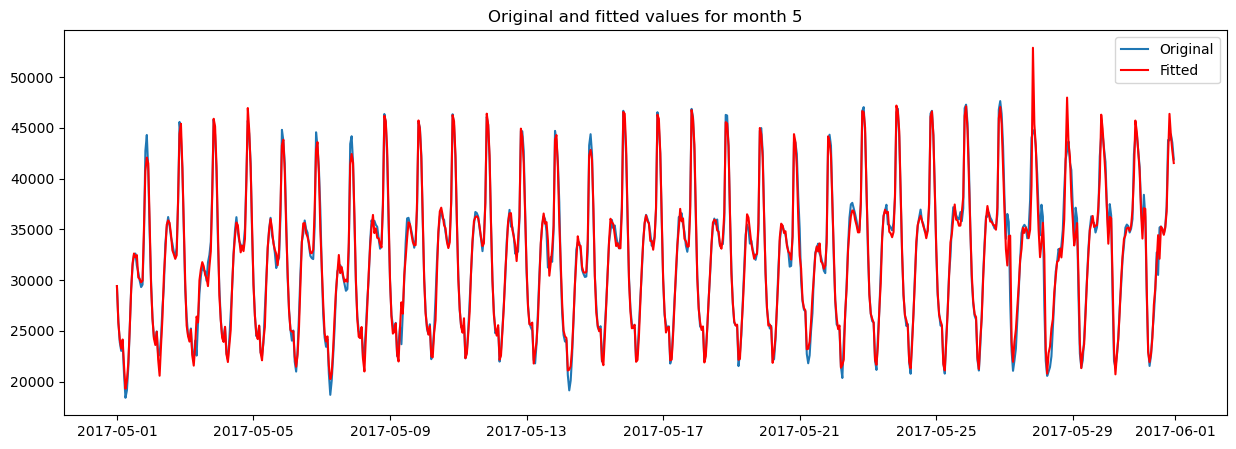

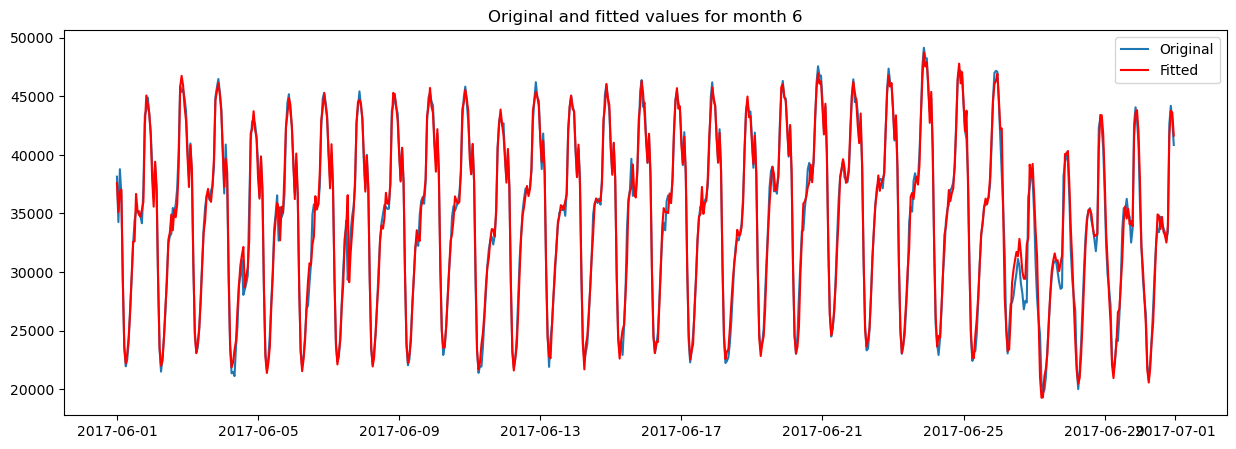

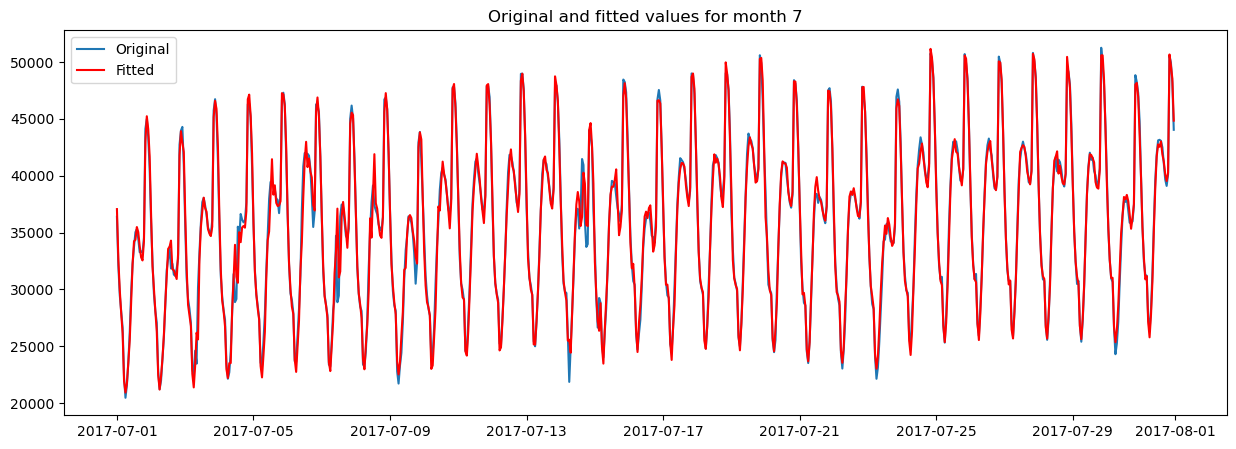

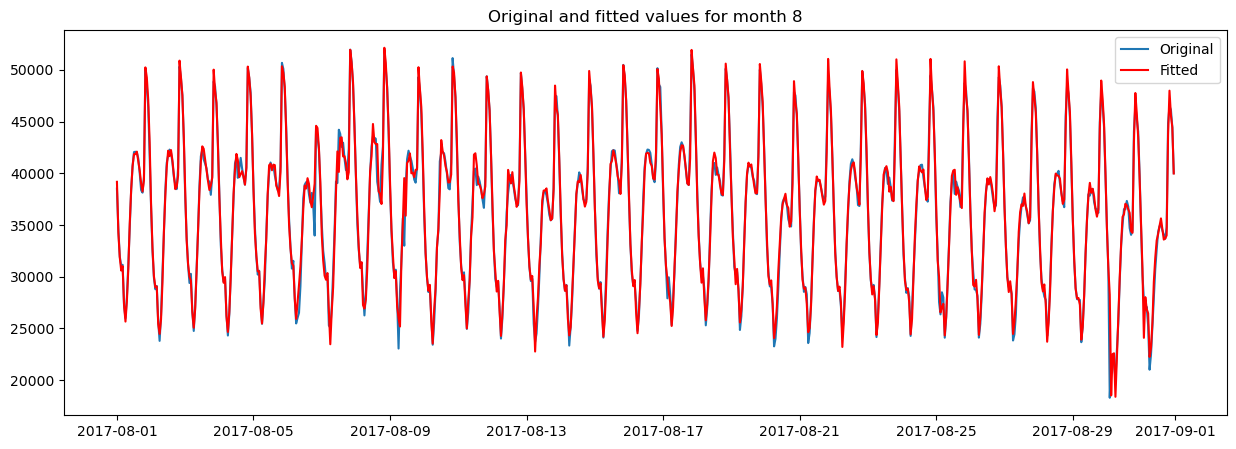

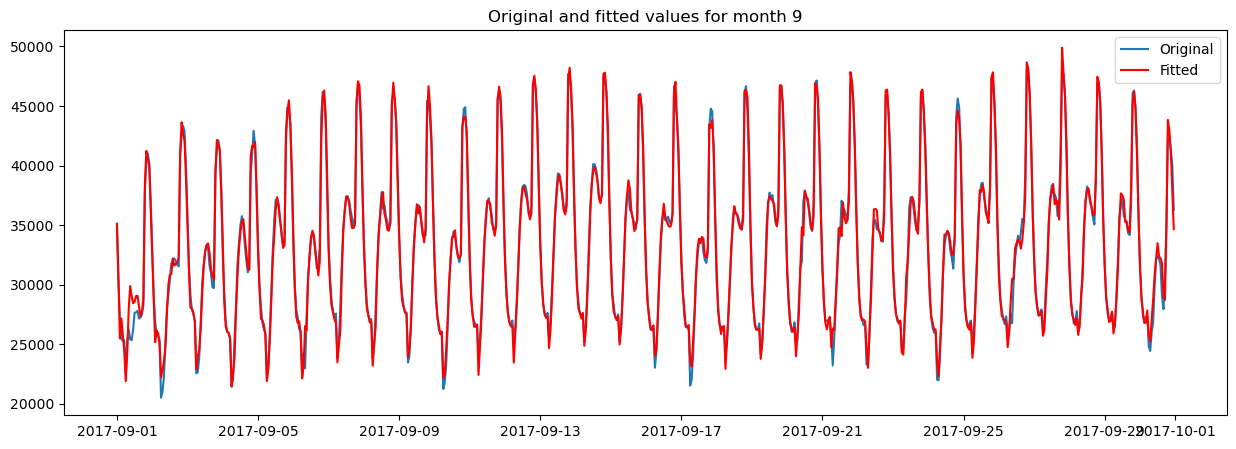

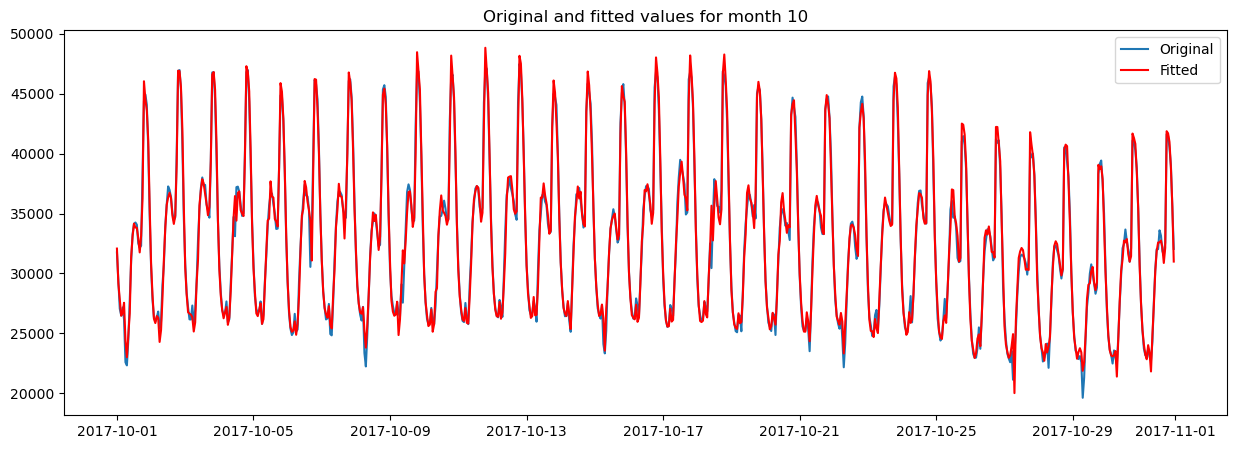

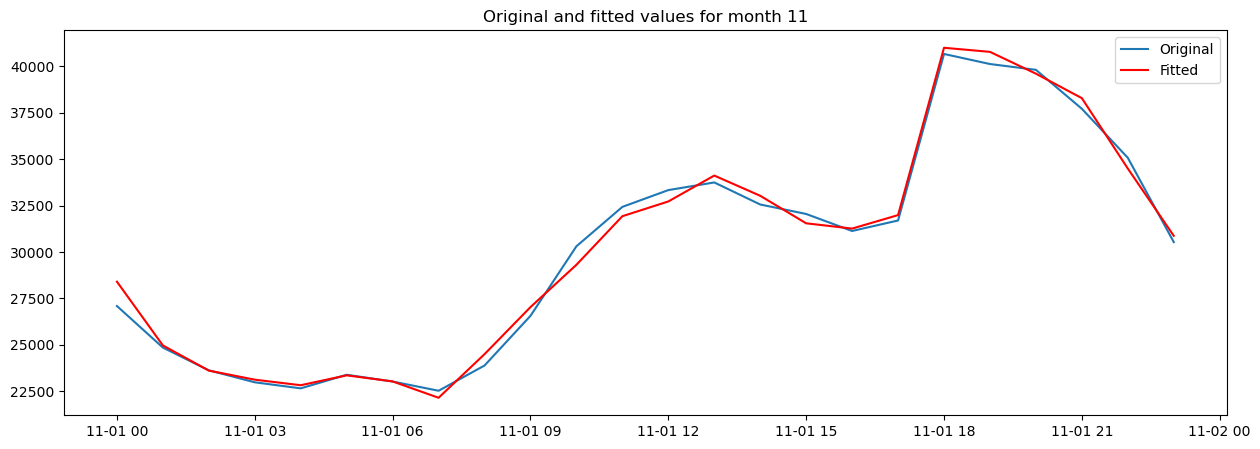

In [244]:
# Plot fitted model through a cycle of one month
for i in pd.unique(train.index.month):
    plt.figure(figsize=(15,5))
    plt.plot(train.loc[train.index.month==i]['y'], label='Original')
    plt.plot(results_a.fittedvalues.loc[train.index.month==i], color='red', label='Fitted')
    plt.title('Original and fitted values for month ' + str(i))
    plt.legend()

In [245]:
# MAE
mean_absolute_error(train['y'], results_a.fittedvalues)

587.4091333837322

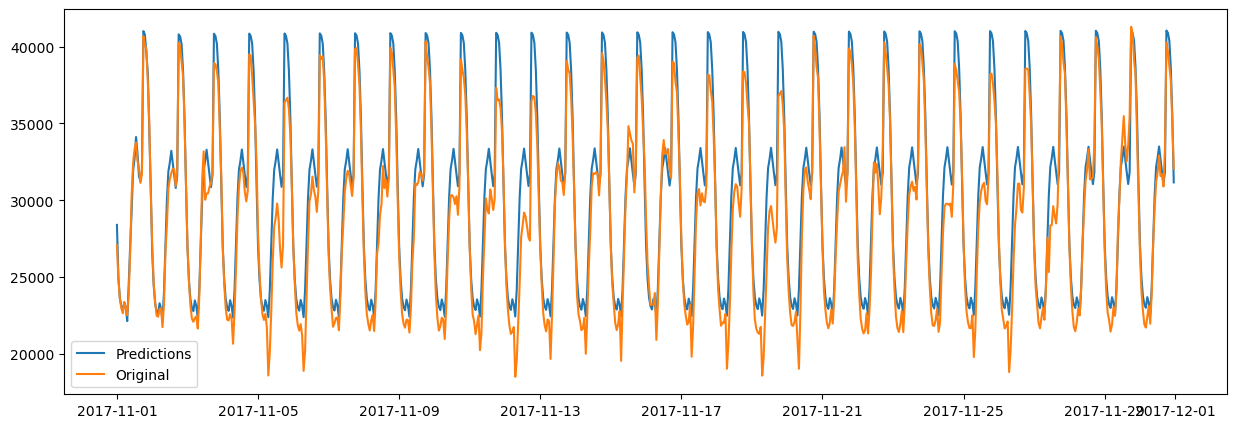

In [246]:
# Predict on test
pred = results_a.predict(start=test.index[0], end=test.index[-1])

# Plot predictions
plt.figure(figsize=(15,5))
plt.plot(pred, label='Predictions')
plt.plot(test['y'], label='Original')
plt.legend()

In [247]:
# MAE on predictions
mean_absolute_error(test['y'], pred)

1395.884088257158

## Dummies

In [42]:
# Add dummy variables for each day of the week
df_sample = pd.get_dummies(df_sample, columns=['Day'])

In [43]:
# Add dummy for season of the year
summer = [pd.to_datetime('2017-06-21'), pd.to_datetime('2017-09-21')]
spring = [pd.to_datetime('2017-03-21'), pd.to_datetime('2017-06-21')]
autumn = [  pd.to_datetime('2017-09-21'), pd.to_datetime('2017-12-21')]
# Add dummy variables for each season of the year
df_sample['Season'] = "winter"
df_sample.loc[(df_sample.index >= summer[0]) & (df_sample.index < summer[1]), 'Season'] = "summer"
df_sample.loc[(df_sample.index >= spring[0]) & (df_sample.index < spring[1]), 'Season'] = "spring"
df_sample.loc[(df_sample.index >= autumn[0]) & (df_sample.index < autumn[1]), 'Season'] = "autumn"


In [44]:
# Add dummy variables for each season of the year
df_sample = pd.get_dummies(df_sample, columns=['Season'])

Non male, ma ristimiamo il modello aggiungendo le dummy del giorno della settimana

In [45]:
# Add Moroccans festivities
moroccan_fest = ["24.04.2017	Lu	Lailat al Miraj	17",
"12.05.2017	Ve	Lailat al Bara'a	19",
"26.05.2017	Ve	Inizio del Ramadan	21",
"22.06.2017	Gi	Laylat al-Qadr	25",
"26.06.2017	Lu	Eid ul-Fitr	26",
"01.09.2017	Ve	Festa del sacrificio (Id al-adha)	35",
"22.09.2017	Ve	Capodanno islamico	38",
"01.10.2017	Do	Ashura	39",
"01.12.2017	Ve	Mawlid	48"]

# Store the data in a dataframe
moroccan_fest = pd.DataFrame([x.split('\t') for x in moroccan_fest], columns=['Date', 'Day', 'Festivity', 'Day of the year'])
moroccan_fest.drop(['Day', "Day of the year"], axis=1, inplace=True)

# Convert the date to datetime
moroccan_fest['Date'] = pd.to_datetime(moroccan_fest['Date'], format='%d.%m.%Y').dt.date

In [46]:
df_sample['Date'] = df_sample.index.date
# Merge the two dataframes
for i, date in enumerate(moroccan_fest['Date']):
    df_sample.loc[df_sample['Date']==date, 'Festivity'] = 1


In [47]:
# Add the column ramadan to the dataframe, from 26.05.2017 to 24.06.2017
df_sample['Ramadan'] = 0    
df_sample.loc[(df_sample.index >= pd.to_datetime('2017-05-26')) & (df_sample.index < pd.to_datetime('2017-06-24')), 'Ramadan'] = 1

In [48]:
df_sample.index.month_name()

Index(['January', 'January', 'January', 'January', 'January', 'January',
       'January', 'January', 'January', 'January',
       ...
       'December', 'December', 'December', 'December', 'December', 'December',
       'December', 'December', 'December', 'January'],
      dtype='object', length=52561)

In [49]:
# Lights hour per day
lights = ["January	08:31 am	06:42 pm	10:11 h",
"February	08:10 am	07:12 pm	11:01 h",
"March	07:36 am	07:35 pm	11:59 h",
"April	05:55 am	06:59 pm	13:04 h",
"May	06:24 am	08:22 pm	13:58 h",
"June	06:14 am	08:41 pm	14:27 h",
"July	06:25 am	08:40 pm	14:15 h",
"August	06:47 am	08:16 pm	13:29 h",
"September	07:09 am	07:36 pm	12:27 h",
"October	07:31 am	06:55 pm	11:24 h",
"November	07:58 am	06:25 pm	10:27 h",
"December	08:23 am	06:20 pm	9:57 h"]

# Store the data in a dataframe
lights = pd.DataFrame([x.split('\t') for x in lights], columns=['Month', 'Sunrise', 'Sunset', 'Lights'])
lights.drop(['Sunrise', "Sunset"], axis=1, inplace=True)

# Convert the column Lights to a float, considering that litghts is currently a measure for hours, in format hh:mm
lights['Lights'] = lights['Lights'].apply(lambda x: x.split(" ")[0])
lights['Lights'] = lights['Lights'].apply(lambda x: float(x.split(":")[0]) + float(x.split(":")[1])/60)
# Add the column lights to the dataframe
df_sample['Lights'] = 0
for i in range(1,13):
    df_sample.loc[df_sample.index.month == i, 'Lights'] = lights.loc[lights['Month']==pd.unique(df_sample.index.month_name())[i-1], 'Lights'].values[0]

In [50]:
temp = ["Time   Jan Feb Mar	Apr	May	Jun	Jul	Aug	Sep	Oct	Nov	Dec",
"Day °C	13	14	17	19	23	25	28	29	25	23	18	14",
"Night °C	11	13	16	19	22	25	28	29	25	23	16	12"]

# Store the data in a dataframe
temp = pd.DataFrame([x.split('\t') for x in temp], columns=['Time', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# Transpose the dataframe
temp = temp.T
# Set the first row as the header
temp.columns = temp.iloc[0]
# Drop the first row
temp = temp[1:]
# Drop the column 'Time   Jan Feb Mar'
temp.drop('Time   Jan Feb Mar', axis=1, inplace=True)
# Convert the index to full month name
temp.index = pd.to_datetime(temp.index, format='%b').month_name()
# Convert the columns to int
temp = temp.apply(pd.to_numeric)

In [51]:
temp

Time       Day °C  Night °C
January        13        11
February       14        13
March          17        16
April          19        19
May            23        22
June           25        25
July           28        28
August         29        29
September      25        25
October        23        23
November       18        16
December       14        12

In [52]:
# Add the columns Day °C and Night °C to df_sample
df_sample['Night °C'] = 0
df_sample['Day °C'] = 0
for i in range(1,13):
   df_sample.loc[df_sample.index.month == i, 'Day °C'] = temp.loc[temp.index==pd.unique(df_sample.index.month_name())[i-1], 'Day °C'].values[0]
for i in range(1,13):
   df_sample.loc[df_sample.index.month == i, 'Night °C'] = temp.loc[temp.index==pd.unique(df_sample.index.month_name())[i-1], 'Night °C'].values[0]


In [53]:
df_sample = df_sample.fillna(0)

In [105]:
train = df_sample.loc[:'2017-10-31'].resample('H').first()
test = df_sample.loc['2017-11-1':"2017-11-30"].resample('H').first()

                     0
y              float64
Hour             int64
Month           object
Day_Domenica     uint8
Day_Giovedì      uint8
Day_Lunedì       uint8
Day_Martedì      uint8
Day_Mercoledì    uint8
Day_Sabato       uint8
Day_Venerdì      uint8
Season_autumn    uint8
Season_spring    uint8
Season_summer    uint8
Season_winter    uint8
Date            object
Festivity      float64
Ramadan          int64
Lights         float64
Night °C         int64
Day °C           int64


In [68]:
dummies = train.columns.to_list()

for x in ["y","Hour","Month","Date", "Day_Lunedì","Season_winter"]:
    dummies.remove(x)

In [69]:
dummies

['Day_Domenica',
 'Day_Giovedì',
 'Day_Martedì',
 'Day_Mercoledì',
 'Day_Sabato',
 'Day_Venerdì',
 'Season_autumn',
 'Season_spring',
 'Season_summer',
 'Festivity',
 'Ramadan',
 'Lights',
 'Night °C',
 'Day °C']

## Model with exogenous variables

In [70]:
model = sm.tsa.statespace.SARIMAX(train['y'], order=(1,1,1), seasonal_order=(0,1,1,24), exog=train[dummies])
results = model.fit()
print(results.summary())

c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 7320
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -59707.351
Date:                            Sun, 29 Jan 2023   AIC                         119450.702
Time:                                    21:31:41   BIC                         119574.811
Sample:                                01-01-2017   HQIC                        119493.379
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Day_Domenica     -9.4225    137.961     -0.068      0.946    -279.822     260.976
Day_Giovedì    -152.0096  

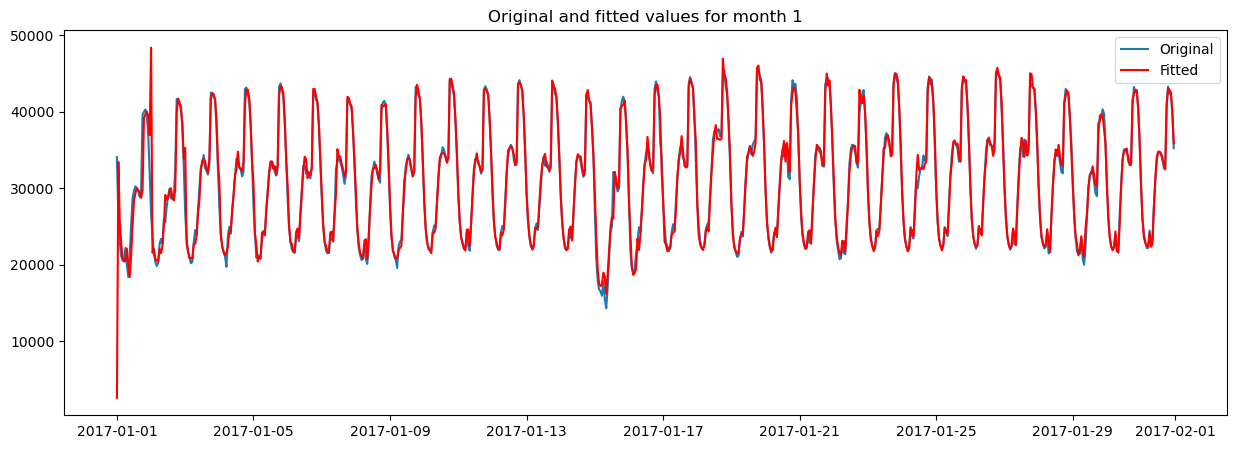

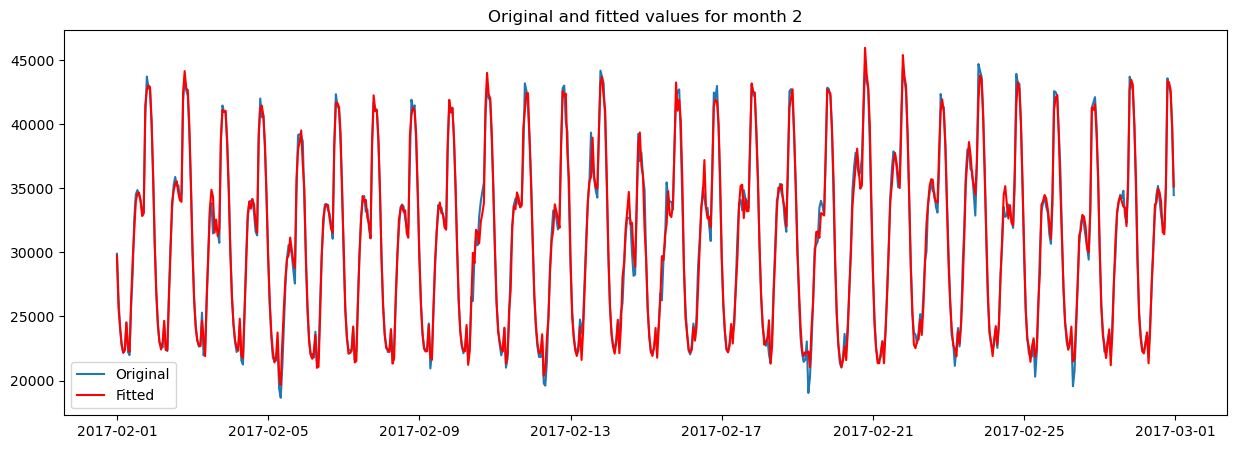

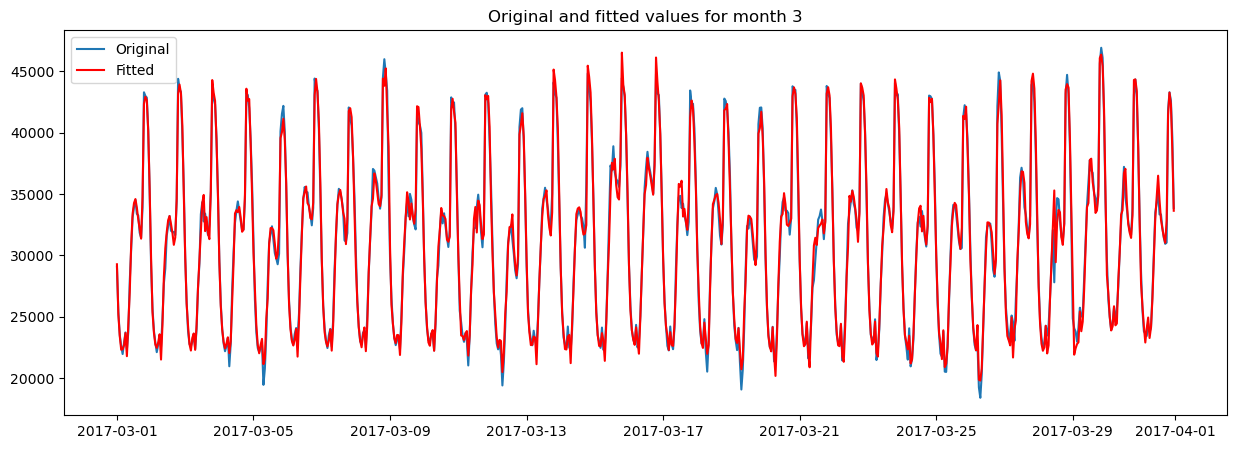

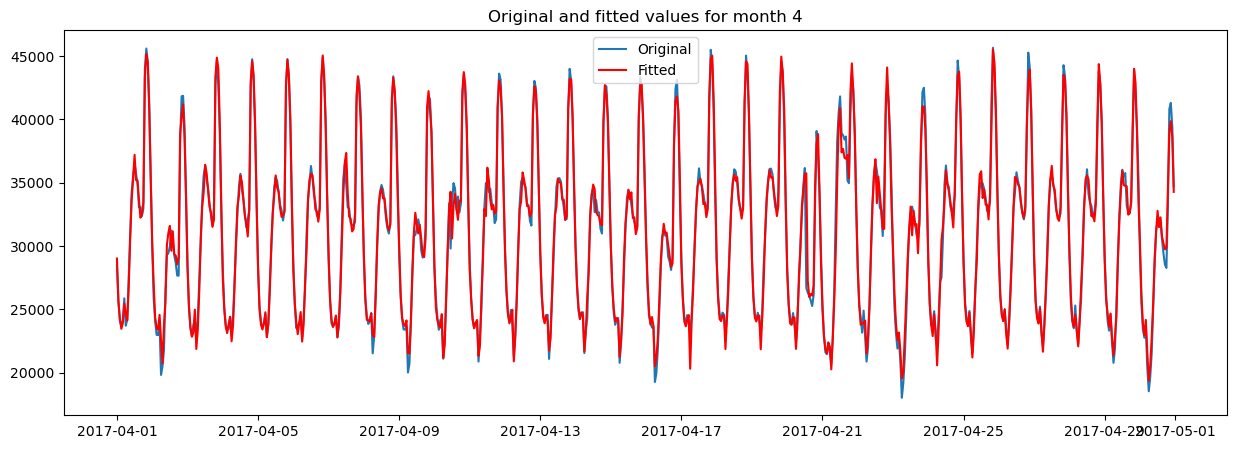

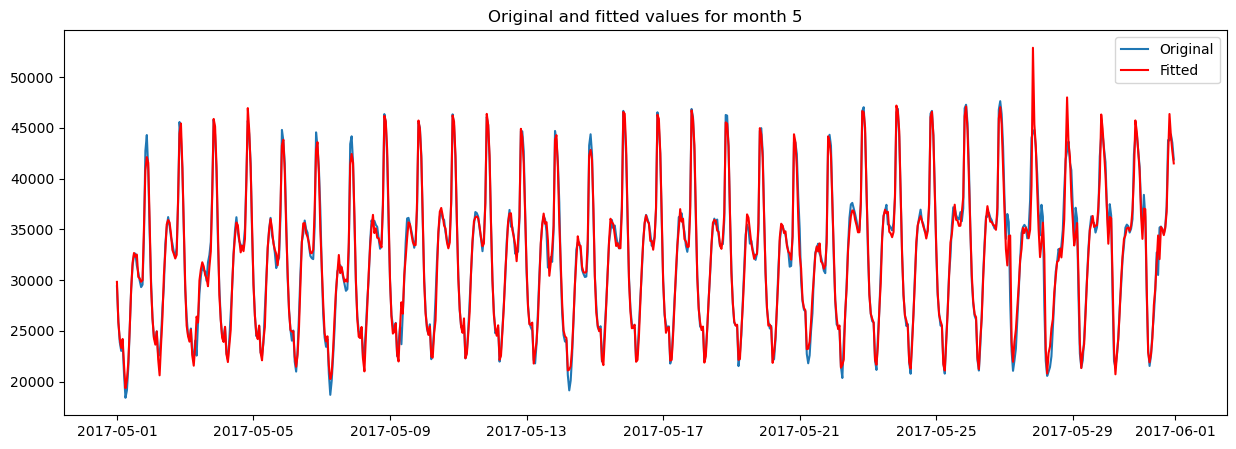

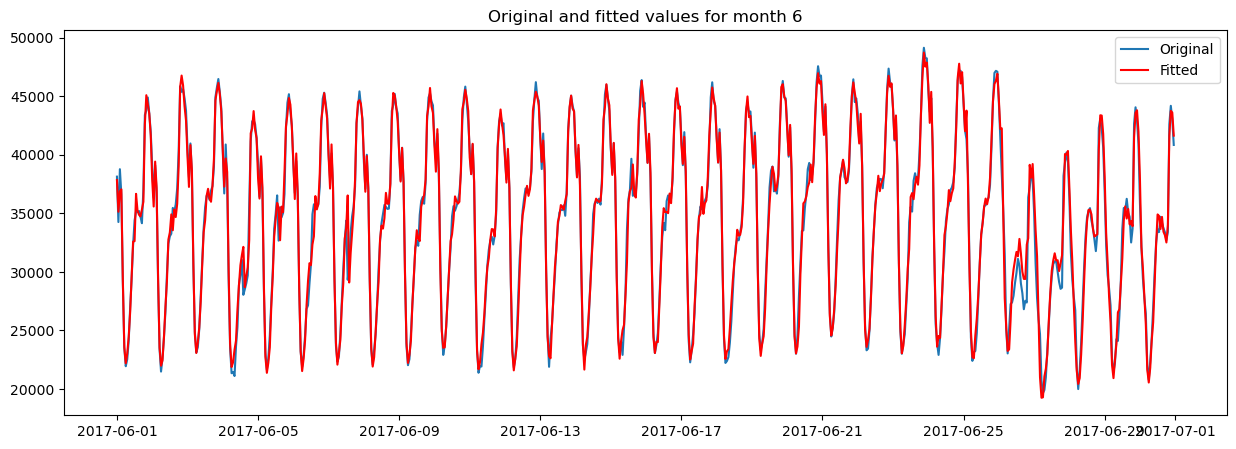

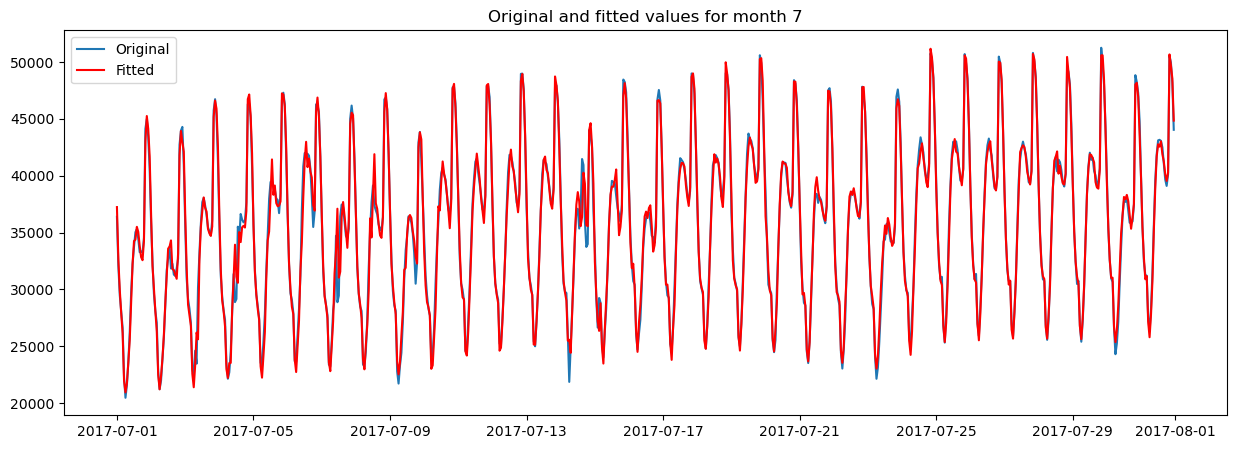

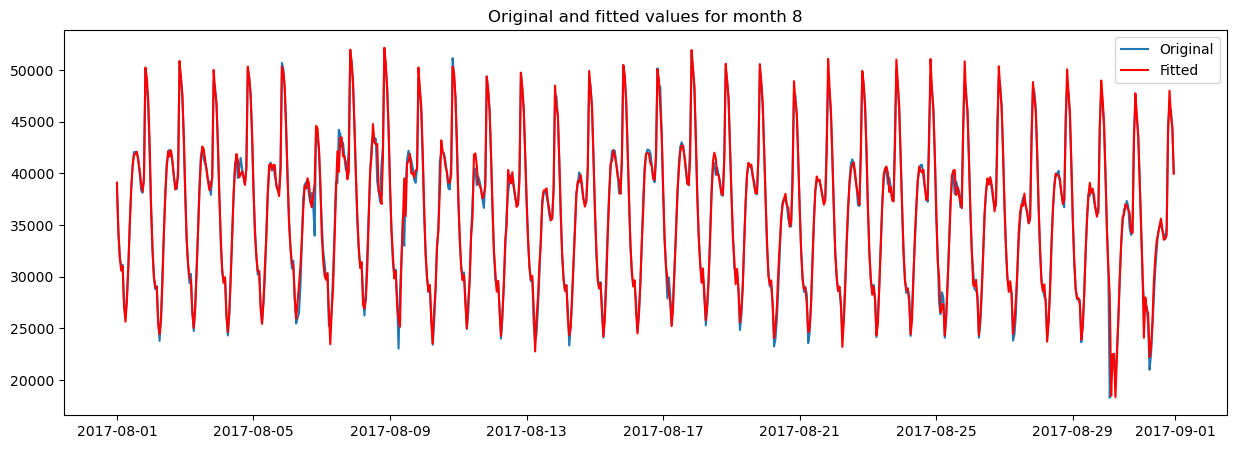

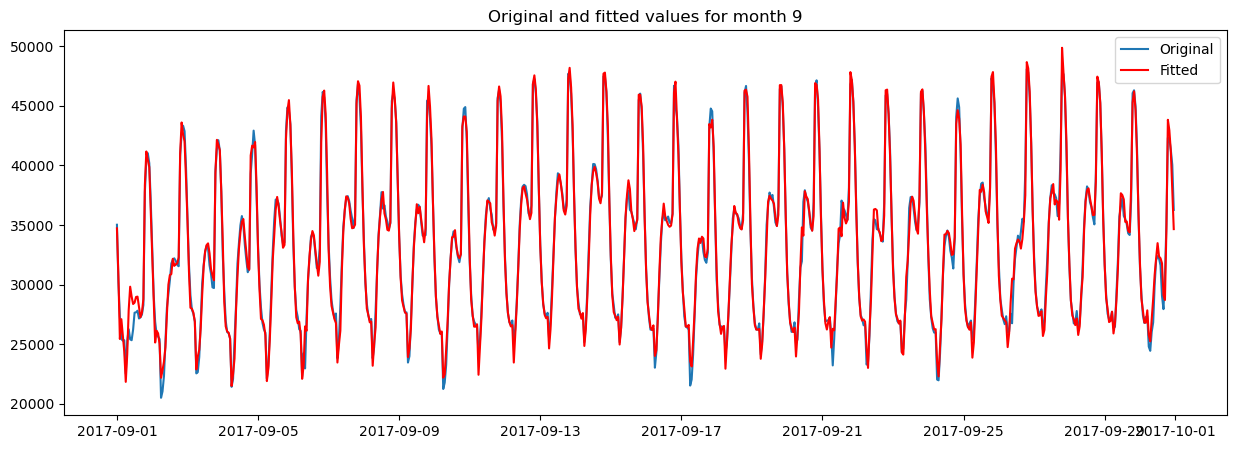

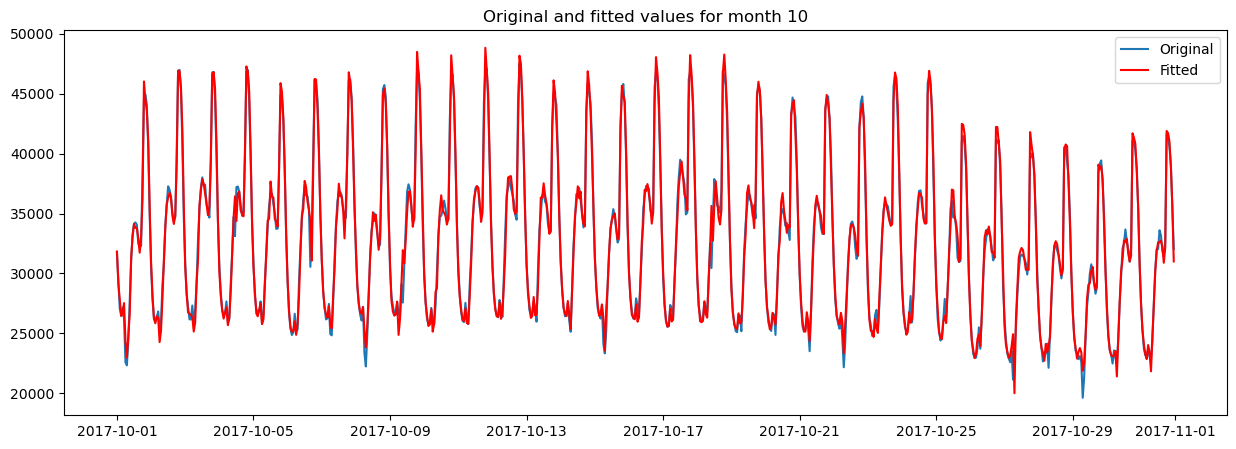

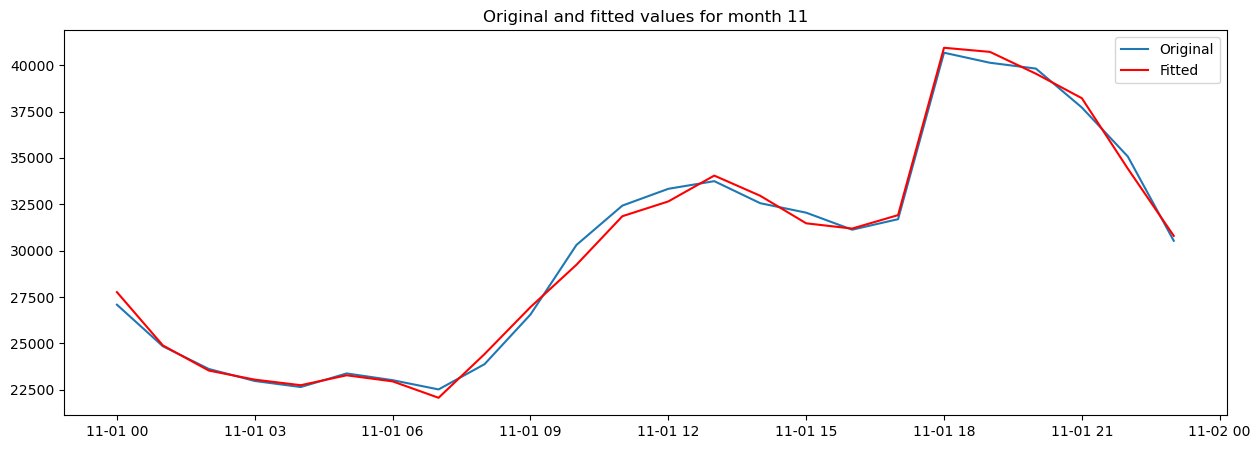

In [274]:
# Plot fitted model through a cycle of one month
for i in pd.unique(train.index.month):
    plt.figure(figsize=(15,5))
    plt.plot(train.loc[train.index.month==i]['y'], label='Original')
    plt.plot(results.fittedvalues.loc[train.index.month==i], color='red', label='Fitted')
    plt.title('Original and fitted values for month ' + str(i))
    plt.legend()

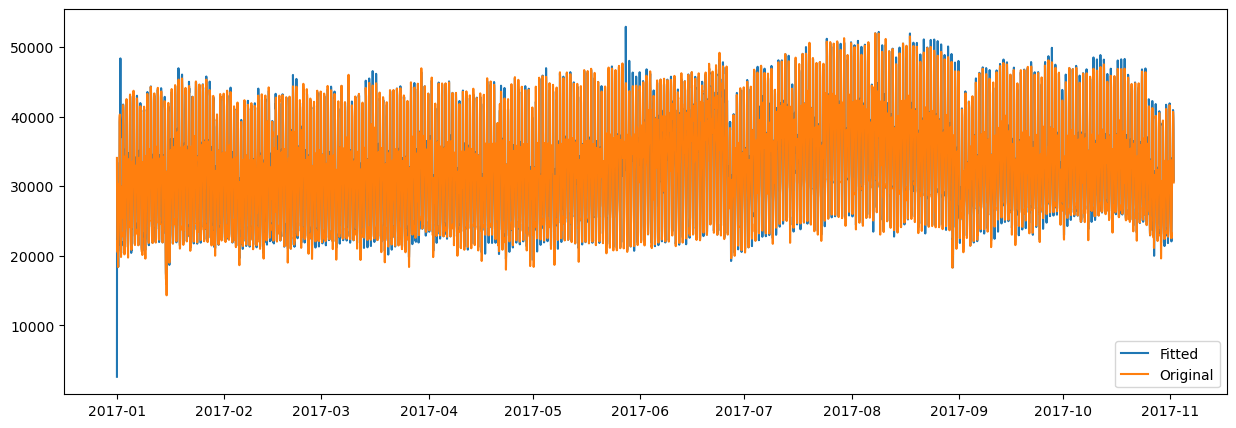

In [275]:
plt.figure(figsize=(15,5))
plt.plot(results.fittedvalues, label='Fitted')
plt.plot(train['y'], label='Original')
plt.legend()

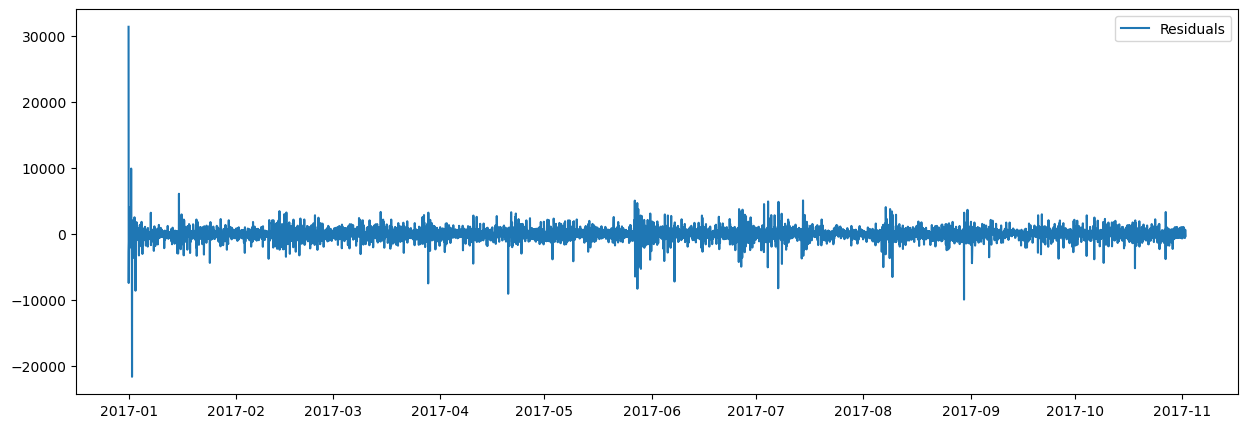

In [276]:
# Plot residuals
plt.figure(figsize=(15,5))
plt.plot(results.resid, label='Residuals')
plt.legend()


c:\Users\matte\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,)

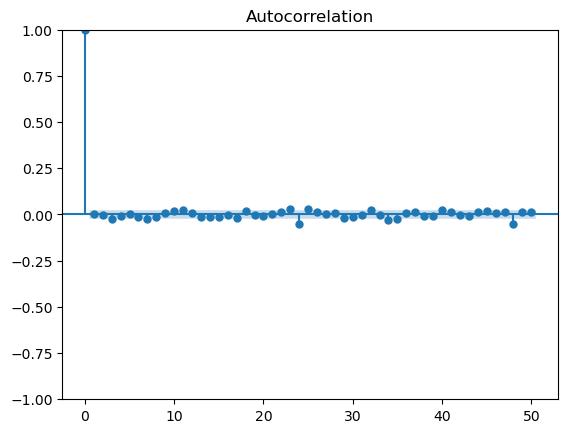

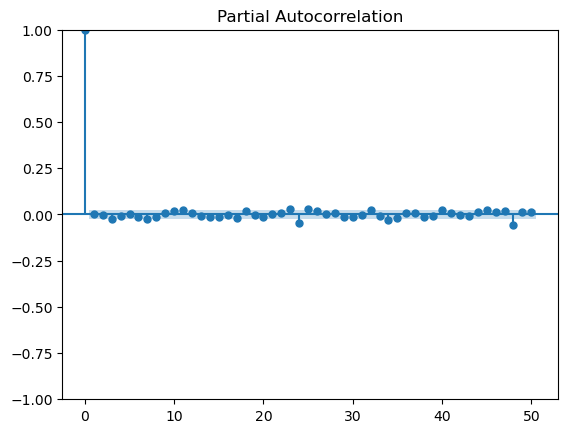

In [277]:
# Plot ACF e PACF dei residui
plot_acf(results.resid, lags=50),
plot_pacf(results.resid, lags=50),


(<AxesSubplot:>,)

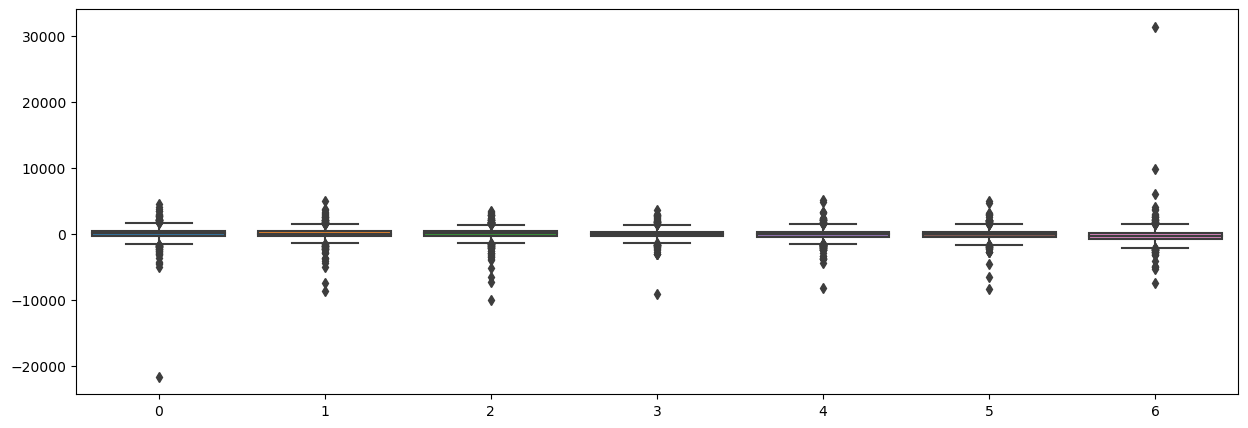

In [278]:
# Plot residuals boxplot by day of the week
plt.figure(figsize=(15,5))
sns.boxplot(x=train.index.day_of_week, y=results.resid, data=train),


Vediamo che la domenica è il giorno con i residui più alti.
Ma cerchiamo anche di capire quali sono le date con i residui più alti, per capire se ci sono dei giorni particolari.

Capodanno va risolto.  Anche i giorni finali di maggio hanno qualcosa che non va. Anche Agosto ha una peculiarità.


In [71]:
# MAE
mean_absolute_error(train['y'], results.fittedvalues)

586.9496011870959

In [280]:
test

y  Hour     Month  Day_Domenica  Day_Giovedì  \
2017-11-01 00:00:00  27089.23077     0  Novembre             0            0   
2017-11-01 01:00:00  24849.23077     1  Novembre             0            0   
2017-11-01 02:00:00  23624.61538     2  Novembre             0            0   
2017-11-01 03:00:00  22978.46154     3  Novembre             0            0   
2017-11-01 04:00:00  22652.30769     4  Novembre             0            0   
...                          ...   ...       ...           ...          ...   
2017-11-30 19:00:00  39692.30769    19  Novembre             0            1   
2017-11-30 20:00:00  38744.61538    20  Novembre             0            1   
2017-11-30 21:00:00  37803.07692    21  Novembre             0            1   
2017-11-30 22:00:00  35150.76923    22  Novembre             0            1   
2017-11-30 23:00:00  32067.69231    23  Novembre             0            1   

                     Day_Lunedì  Day_Martedì  Day_Mercoledì  Day_Sabato  \
2017-11-01 00:00:00           0            0              1           0   
2017-11-01 01:00:00           0            0              1           0   
2017-11-01 02:00:00           0            0              1           0   
2017-11-01 03:00:00           0            0              1           0   
2017-11-01 04:00:00           0            0              1           0   
...                         ...          ...            ...         ...   
2017-11-30 19:00:00           0            0              0           0   
2017-11-30 20:00:00           0            0              0           0   
2017-11-30 21:00:00           0            0              0           0   
2017-11-30 22:00:00           0            0              0           0   
2017-11-30 23:00:00           0            0              0           0   

                     Day_Venerdì  Season_autumn  Season_spring  Season_summer  \
2017-11-01 00:00:00            0              1              0              0   
2017-11-01 01:00:00            0              1              0              0   
2017-11-01 02:00:00            0              1              0              0   
2017-11-01 03:00:00            0              1              0              0   
2017-11-01 04:00:00            0              1              0              0   
...                          ...            ...            ...            ...   
2017-11-30 19:00:00            0              1              0              0   
2017-11-30 20:00:00            0              1              0              0   
2017-11-30 21:00:00            0              1              0              0   
2017-11-30 22:00:00            0              1              0              0   
2017-11-30 23:00:00            0              1              0              0   

                     Season_winter        Date  Festivity  Ramadan  Lights  \
2017-11-01 00:00:00              0  2017-11-01        0.0        0   10.45   
2017-11-01 01:00:00              0  2017-11-01        0.0        0   10.45   
2017-11-01 02:00:00              0  2017-11-01        0.0        0   10.45   
2017-11-01 03:00:00              0  2017-11-01        0.0        0   10.45   
2017-11-01 04:00:00              0  2017-11-01        0.0        0   10.45   
...                            ...         ...        ...      ...     ...   
2017-11-30 19:00:00              0  2017-11-30        0.0        0   10.45   
2017-11-30 20:00:00              0  2017-11-30        0.0        0   10.45   
2017-11-30 21:00:00              0  2017-11-30        0.0        0   10.45   
2017-11-30 22:00:00              0  2017-11-30        0.0        0   10.45   
2017-11-30 23:00:00              0  2017-11-30        0.0        0   10.45   

                     Night °C  Day °C  
2017-11-01 00:00:00        16      18  
2017-11-01 01:00:00        16      18  
2017-11-01 02:00:00        16      18  
2017-11-01 03:00:00        16      18  
2017-11-01 04:00:00        16      18  
...                       ...  

In [281]:
test.index[0]

Timestamp('2017-11-01 00:00:00', freq='H')

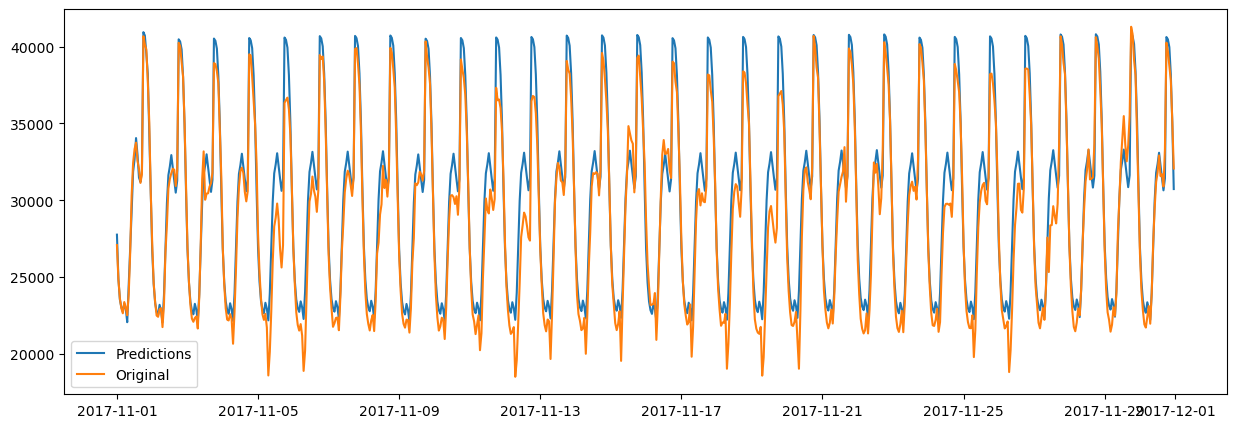

In [282]:
# Predict on test
pred = results.predict(start=test.index[0], end=test.index[-1], exog=test.iloc[:696][dummies])
# Confidence intervals

# Plot predictions
plt.figure(figsize=(15,5))
plt.plot(pred, label='Predictions')
plt.plot(test['y'], label='Original')
plt.legend()



L'anno scolastico inizia a Ottobre e finisce a Giugno ed è organizzato in tre trimestri. Durante l'anno sono previste vacanze a Dicembre e a primavera. I giorni di frequenza settimanali sono 5, il Venerdì e la Domenica sono festivi; alle medie e alle superiori invece, gli studenti vanno a scuola sei giorni alla settimana. Le ore di lezioni settimanali sono 28, ma esistono grandi variazioni fra scuole urbane e rurali, scuole pubbliche e private.

In [283]:
# MAE
mean_absolute_error(test['y'], pred)

1232.883343536119

il miglior modello sarà il SARIMAX(3,0,1)x(0,1,1)24, con le variabili esogene.

# UCM

In [150]:
import itertools
level = ['local linear trend']
seasonal = [24]
stochastic_seasonal = [True]
damped_cycle = [False]
stochastic_cycle = [False]
autoregressive = [1]
exog = [train[dummies]]

# Create a list of all the possible combinations of the parameters
possible_params = list(itertools.product(level, seasonal, stochastic_seasonal, damped_cycle, stochastic_cycle, autoregressive, exog))

In [151]:
# Create a dataframe with the parameters as columns and the values as rows
metrics = pd.DataFrame(possible_params, columns=["trend", "seasonal",  "stochastic_seasonal", "damped_cycle", "stochastic_cycle","autoregressive","exog"])

In [152]:
metrics[['MAE_train', 'MAE_test','AIC']] = 0

In [153]:
metrics

trend  seasonal  stochastic_seasonal  damped_cycle  \
0  local linear trend        24                 True         False   

   stochastic_cycle  autoregressive  \
0             False               1   

                                                exog  MAE_train  MAE_test  AIC  
0                       Day_Domenica  Day_Giovedì...          0         0    0

In [154]:
# For each combination of parameters, fit the model and store the results in the dataframe metrics
for i in range(0,len(metrics)):
    model = sm.tsa.UnobservedComponents(train['y'], level=possible_params[i][0], seasonal=possible_params[i][1] ,stochastic_seasonal=possible_params[i][2], damped_cycle=possible_params[i][3], stochastic_cycle=possible_params[i][4], autoregressive=possible_params[i][5], exog=train[dummies])
    result = model.fit()
    metrics.loc[i, 'MAE_train'] = mean_absolute_error(train['y'], result.predict(train.index[0], train.index[-1], exog=train[dummies]))
    metrics.loc[i, 'MAE_test'] = mean_absolute_error(test['y'], result.predict(test.index[0], test.index[-1], exog=test[dummies]))
    metrics.loc[i, 'AIC'] = result.aic

    print("Done " + str(i+1) + " of " + str(len(possible_params)))

Done 1 of 1


In [155]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                             y   No. Observations:                 7296
Model:                    local linear trend   Log Likelihood              -61168.612
                   + stochastic seasonal(24)   AIC                         122377.225
                                     + AR(1)   BIC                         122515.058
Date:                       Sun, 29 Jan 2023   HQIC                        122424.629
Time:                               22:59:55                                         
Sample:                           01-01-2017                                         
                                - 10-31-2017                                         
Covariance Type:                         opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.irregular       2.0791   6719.198      0.000      1.000   -1.32e+04    1.32e+04
sigma2.level        2.624e+04   5800.671      4.524      0.000    1.49e+04    3.76e+04
sigma2.trend        4.464e-06      1.086   4.11e-06      1.000      -2.128       2.128
sigma2.seasonal     5.119e+04   1636.831     31.273      0.000     4.8e+04    5.44e+04
sigma2.ar           5.888e+05   5800.673    101.501      0.000    5.77e+05       6e+05
ar.L1                  1.0000      0.008    132.773      0.000       0.985       1.015
beta.Day_Domenica   -123.2488    114.478     -1.077      0.282    -347.622     101.125
beta.Day_Giovedì    -196.4575    192.392     -1.021      0.307    -573.539     180.624
beta.Day_Martedì     -49.4013    118.673     -0.416      0.677    -281.996     183.194
beta.Day_Mercoledì  -257.1414    161.613     -1.591      0.112    -573.898      59.615
beta.Day_Sabato     -236.8676    156.179     -1.517      0.129    -542.972      69.237
beta.Day_Venerdì    -191.9833    198.993     -0.965      0.335    -582.002     198.036
beta.Season_autumn    44.7089   5849.115      0.008      0.994   -1.14e+04    1.15e+04
beta.Season_spring    -8.5931   5410.138     -0.002      0.999   -1.06e+04    1.06e+04
beta.Season_summer    81.7978   5444.034      0.015      0.988   -1.06e+04    1.08e+04
beta.Festivity       -84.4625    319.669     -0.264      0.792    -711.002     542.077
beta.Ramadan         -25.2519    949.617     -0.027      0.979   -1886.467    1835.963
beta.Lights           21.3954    812.669      0.026      0.979   -1571.406    1614.197
beta.Night °C        -36.9032    554.595     -0.067      0.947   -1123.890    1050.083
beta.Day °C           10.6003    635.209      0.017      0.987   -1234.386    1255.587
===================================================================================
Ljung-Box (L1) (Q):                1119.88   Jarque-Bera (JB):             10105.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.43e+16. Standard errors may be unstable.
"""

In [ ]:
fitted_values = result.predict(train.index[0], train.index[-1])
# Plot fitted model through a cycle of one month
for i in pd.unique(train.index.month):
    plt.figure(figsize=(15,5))
    plt.plot(train.loc[train.index.month==i]['y'], label='Original')
    plt.plot(fitted_values.loc[train.index.month==i], color='red', label='Fitted',alpha=0.5)
    plt.title('Original and fitted values for month ' + str(i))
    plt.legend()

In [156]:
metrics

trend  seasonal  stochastic_seasonal  damped_cycle  \
0  local linear trend        24                 True         False   

   stochastic_cycle  autoregressive  \
0             False               1   

                                                exog   MAE_train     MAE_test  \
0                       Day_Domenica  Day_Giovedì...  795.879354  1444.485092   

             AIC  
0  122377.224778

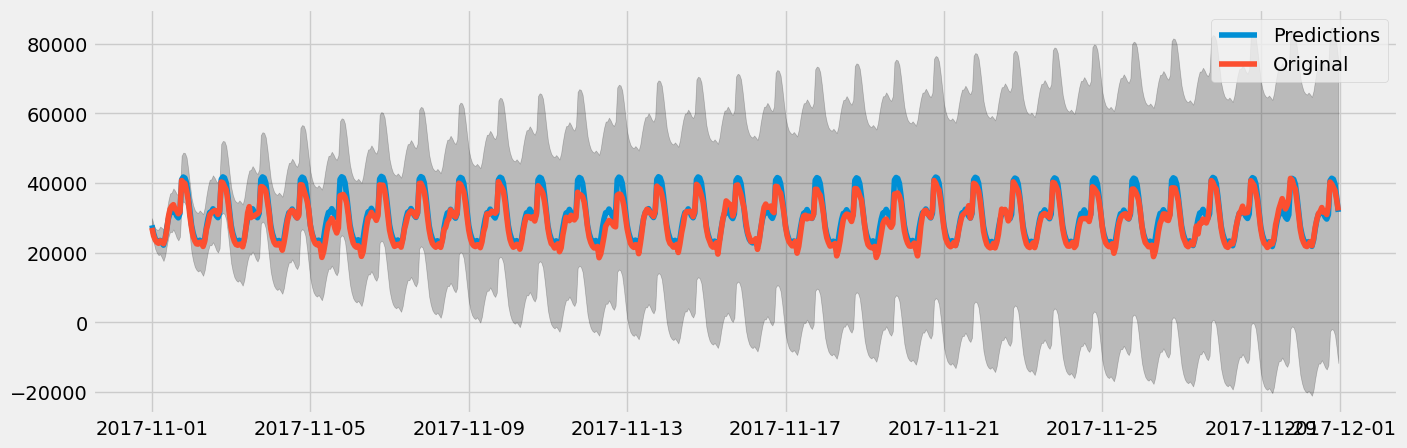

In [157]:
# Predict on test set and plot, include confidence intervals

pred = result.predict(test.index[0], test.index[-1], exog=test[dummies], confidence_level=0.95)
pred_ci = result.get_forecast(steps=len(test), exog=test[dummies]).conf_int()

plt.figure(figsize=(15,5))
plt.plot(pred, label='Predictions')
plt.plot(test['y'], label='Original')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.legend()
plt.show()


In [ ]:
# View the results
print(result.summary())


## Machine Learning

In [ ]:
def create_features(df, label=None, split_date=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['minute'] = df['date'].dt.minute
    
    X_train = df[df.columns].loc[:split_date]
    X_test = df[df.columns].loc[split_date:]
    
    if label:
        y_train = df[label].loc[:split_date]
        y_test = df[label].loc[split_date:]
        return X_train, y_train, X_test, y_test
    return X_train, X_test

X_train, y_train, X_test, y_test = create_features(df_sample, label='y', split_date=pd.to_datetime('2017-11-1'))

In [ ]:
drop = ['Day_Domenica', 'Day_Giovedì', 'Day_Lunedì', 'Day_Martedì', 'Day_Mercoledì', 'Day_Sabato', 'Day_Venerdì', 'Date','date', "Month", "y"]

# Drop the date features
X_train = X_train.drop(drop, axis=1)
X_test = X_test.drop(drop, axis=1)
X_train.index.freq = "10T"
y_train.index.freq = "10T"

In [ ]:
columns = X_train.columns

In [ ]:
X_train.dtypes

In [ ]:
# Grid search for best XGBoost
model = xgb.XGBRegressor(n_estimators=1000, max_depth=25, learning_rate=0.05, subsample=1, colsample_bytree=0.7, n_jobs=5)

In [ ]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        eval_metric="mae",
       verbose=True) # Change verbose to True if you want to see it train

    

In [ ]:
# Predict on test set and plot, include confidence intervals
predictions_ml =model.predict(X_test)
predictions_ml = pd.Series(predictions_ml, index=y_test.index)

plt.figure(figsize=(15,5))
plt.plot(predictions_ml, label='Predictions', lw=1)
plt.plot(y_test, label='Original', lw=1)
plt.legend()
plt.show()

In [ ]:
# Compute the mean absolute error
mean_absolute_error(y_test, predictions_ml)

In [ ]:
# Plot the feature importance
plot_importance(model, max_num_features=10)
plt.show()

# Prepare the dataset for the sumbission
the dataset should have the same columns of the train and test

In [72]:
submission_train_00 = df_sample.loc[:'2017-11-30']

# Split the training set in two parts, one containing minute 00 and one containing minute 30
submission_train_30 = submission_train_00.loc[submission_train_00.index.minute == 30]
submission_train_10 = submission_train_00.loc[submission_train_00.index.minute == 10]
submission_train_20 = submission_train_00.loc[submission_train_00.index.minute == 20]
submission_train_40 = submission_train_00.loc[submission_train_00.index.minute == 40]
submission_train_50 = submission_train_00.loc[submission_train_00.index.minute == 50]
submission_train_00 = submission_train_00.loc[submission_train_00.index.minute == 0]

In [73]:
dec = df_sample.loc["2017-12-1":]
#dec.drop(["hour","dayofweek","month", "date"], axis=1, inplace=True)

# Stima dei modelli ARIMA con i migliori risultati trovati

In [ ]:
model = sm.tsa.statespace.SARIMAX(submission_train_00["y"], order=(1,1,1), seasonal_order=(0,1,1,24), exog=submission_train_00[dummies]).fit()
predictions_00 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.statespace.SARIMAX(submission_train_10["y"], order=(1,1,1), seasonal_order=(0,1,1,24), exog=submission_train_10[dummies]).fit()
predictions_10 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.statespace.SARIMAX(submission_train_20["y"], order=(1,1,1), seasonal_order=(0,1,1,24), exog=submission_train_20[dummies]).fit()
predictions_20 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.statespace.SARIMAX(submission_train_30["y"], order=(1,1,1), seasonal_order=(0,1,1,24), exog=submission_train_30[dummies]).fit()
predictions_30 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.statespace.SARIMAX(submission_train_40["y"], order=(1,1,1), seasonal_order=(0,1,1,24), exog=submission_train_40[dummies]).fit()
predictions_40 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.statespace.SARIMAX(submission_train_50["y"], order=(1,1,1), seasonal_order=(0,1,1,24), exog=submission_train_50[dummies]).fit()
predictions_50 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())

In [ ]:
# Concatenate the two predictions
predictions = pd.concat([predictions_00, predictions_30, predictions_10, predictions_20, predictions_40, predictions_50])
# Sort the predictions by index
predictions = predictions.sort_index()

In [288]:
predictions.to_csv("arima.csv", header=True)

In [158]:
# Now we will do the same thing with the UCM model
model = sm.tsa.UnobservedComponents(submission_train_00['y'], level="local linear trend", seasonal=24 ,stochastic_seasonal=True,
                                    damped_cycle=False, stochastic_cycle=False, autoregressive=1, exog=submission_train_00[dummies]).fit()
predictions_00 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.UnobservedComponents(submission_train_10['y'], level="local linear trend", seasonal=24 ,stochastic_seasonal=True,
                                    damped_cycle=False, stochastic_cycle=False, autoregressive=1, exog=submission_train_10[dummies]).fit()
predictions_10 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.UnobservedComponents(submission_train_20['y'], level="local linear trend", seasonal=24 ,stochastic_seasonal=True,
                                    damped_cycle=False, stochastic_cycle=False, autoregressive=1, exog=submission_train_20[dummies]).fit()  
predictions_20 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.UnobservedComponents(submission_train_30['y'], level="local linear trend", seasonal=24 ,stochastic_seasonal=True,
                                    damped_cycle=False, stochastic_cycle=False, autoregressive=1, exog=submission_train_30[dummies]).fit()
predictions_30 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.UnobservedComponents(submission_train_40['y'], level="local linear trend", seasonal=24 ,stochastic_seasonal=True,
                                    damped_cycle=False, stochastic_cycle=False, autoregressive=1, exog=submission_train_40[dummies]).fit()
predictions_40 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())
model = sm.tsa.UnobservedComponents(submission_train_50['y'], level="local linear trend", seasonal=24 ,stochastic_seasonal=True,
                                    damped_cycle=False, stochastic_cycle=False, autoregressive=1, exog=submission_train_50[dummies]).fit()
predictions_50 = model.predict(start=dec.index[0], end=dec.index[-1], exog=dec[dummies].resample("H").first())


c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\matte\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency inform

In [159]:
# Concatenate the two predictions
predictions_ucm = pd.concat([predictions_00, predictions_30, predictions_10, predictions_20, predictions_40, predictions_50])
# Sort the predictions by index
predictions_ucm = predictions_ucm.sort_index()

C:\Users\matte\AppData\Local\Temp\ipykernel_15740\1519664927.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


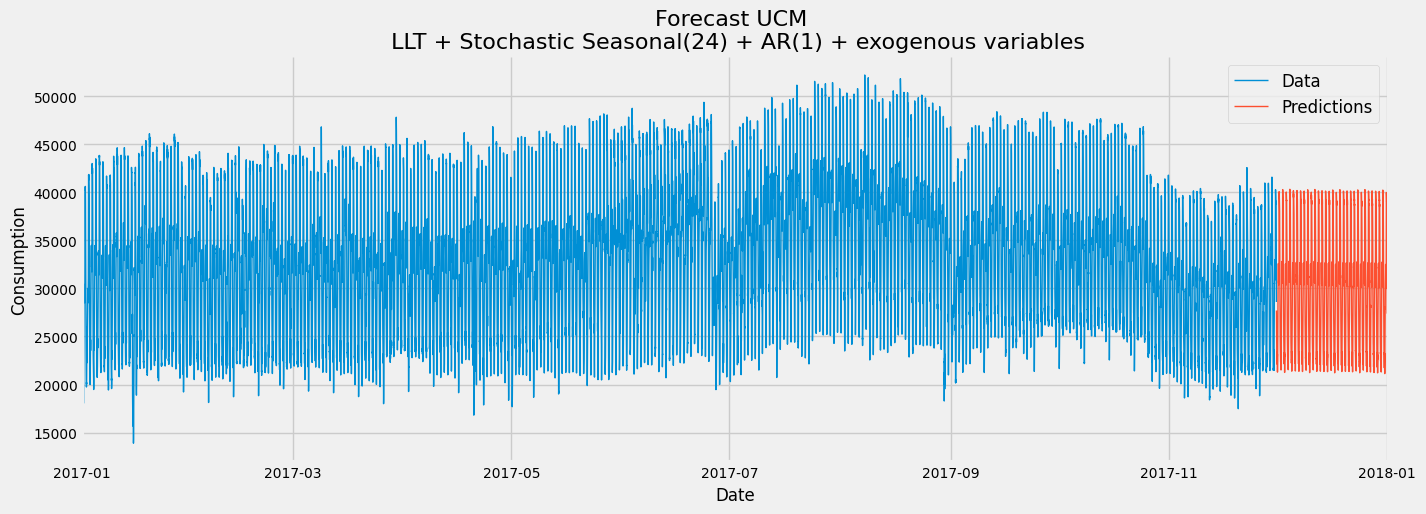

In [164]:
# Plot data and predictions
plt.figure(figsize=(15,5))
plt.plot(df["y"], lw=1, label="Data")
plt.plot(predictions_ucm, lw=1, label="Predictions")
# Add the grid to the plot
plt.grid(b=True)
plt.ylabel('Consumption', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title("Forecast UCM \n LLT + Stochastic Seasonal(24) + AR(1) + exogenous variables", fontsize=16)
plt.xlim(pd.to_datetime("2017-1-1"), pd.to_datetime("2018-1-1"))
# Remove top and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Reduce ticks fontsize
plt.tick_params(axis='both', which='major', labelsize=10)
# Add legend, fontsize 12
plt.legend(loc='upper right', fontsize=12)
# Save the plot
plt.savefig("ucm.png", bbox_inches='tight')
plt.show()

In [162]:
predictions_ucm.to_csv("ucm.csv", header=True)

In [165]:
predictions = pd.read_csv("arima.csv", index_col=0, parse_dates=True)

C:\Users\matte\AppData\Local\Temp\ipykernel_15740\2782070041.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


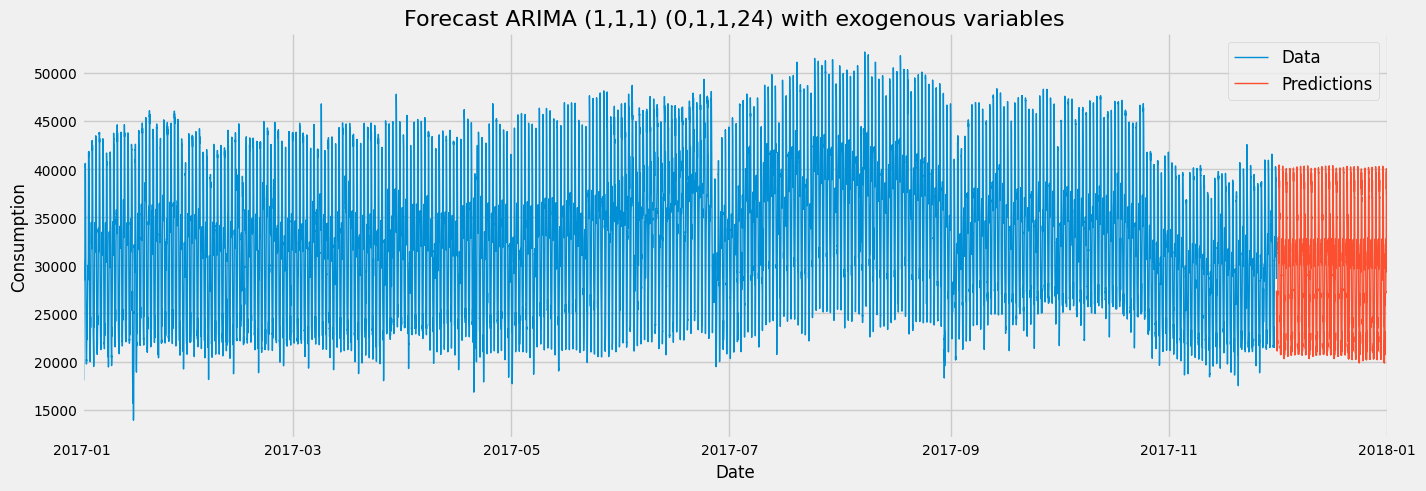

In [166]:
# Plot data and predictions
plt.figure(figsize=(15,5))
plt.plot(df["y"], lw=1, label="Data")
plt.plot(predictions, lw=1, label="Predictions")
# Add the grid to the plot
plt.grid(b=True)
plt.ylabel('Consumption', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title("Forecast ARIMA (1,1,1) (0,1,1,24) with exogenous variables", fontsize=16)
plt.xlim(pd.to_datetime("2017-1-1"), pd.to_datetime("2018-1-1"))
# Remove top and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Reduce ticks fontsize
plt.tick_params(axis='both', which='major', labelsize=10)
# Add legend, fontsize 12
plt.legend(loc='upper right', fontsize=12)
# Save the plot
plt.savefig("arima.png", bbox_inches='tight')
plt.show()


In [96]:
#Print predictions min and max index
print(predictions.index.min())
print(predictions.index.max())

2017-12-01 00:00:00
2017-12-31 23:50:00


# TCN Definition

In [38]:
!pip install keras-tcn

  Using cached numpy-1.19.5-cp39-cp39-win_amd64.whl (13.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.1
    Uninstalling numpy-1.24.1:
      Successfully uninstalled numpy-1.24.1


ERROR: Could not install packages due to an OSError: [WinError 5] Accesso negato: 'C:\\Users\\matte\\anaconda3\\Lib\\site-packages\\~.mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [40]:
# We will create a Temporal Convolutional Network (TCN) to predict the next month of energy consumption.



lookback_window = 1008 


ts = df.loc[:"2017-11-1"]["y"].values  # just keep np array here for simplicity.
mean = ts.mean()
std = ts.std()
# Normalize the data before feeding it to the network
ts = (ts - np.mean(ts)) / np.std(ts)

x, y = [], []
for i in range(lookback_window, len(ts)):
    x.append(ts[i - lookback_window:i])
    y.append(ts[i])
x = np.array(x)
y = np.array(y)

c:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:585: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'

In [93]:
# Len of one month
len_one_month = 24 * 7 * 6
len_one_month

1008

In [ ]:
print(x.shape)
print(y.shape)

model = Sequential([
    TCN(input_shape=(lookback_window, 1),
        kernel_size=2,
        dilations=[1, 6, 72, 144, 288, 1008],
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(1, activation='linear')
])

model.summary()
model.compile('adam', 'mae')

print('Train...')
model.fit(x, y, epochs=100, verbose=True)

p = model.predict(x)

# Inverse the normalization
p = p * std + mean
y = y * std + mean

plt.plot(p)
plt.plot(y)
plt.title('energy consumption')
plt.legend(['predicted', 'actual'])
plt.show()


In [4]:
tcn = pd.read_csv("tcn.csv", index_col=0, parse_dates=True)

C:\Users\matte\AppData\Local\Temp\ipykernel_17396\4027707522.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


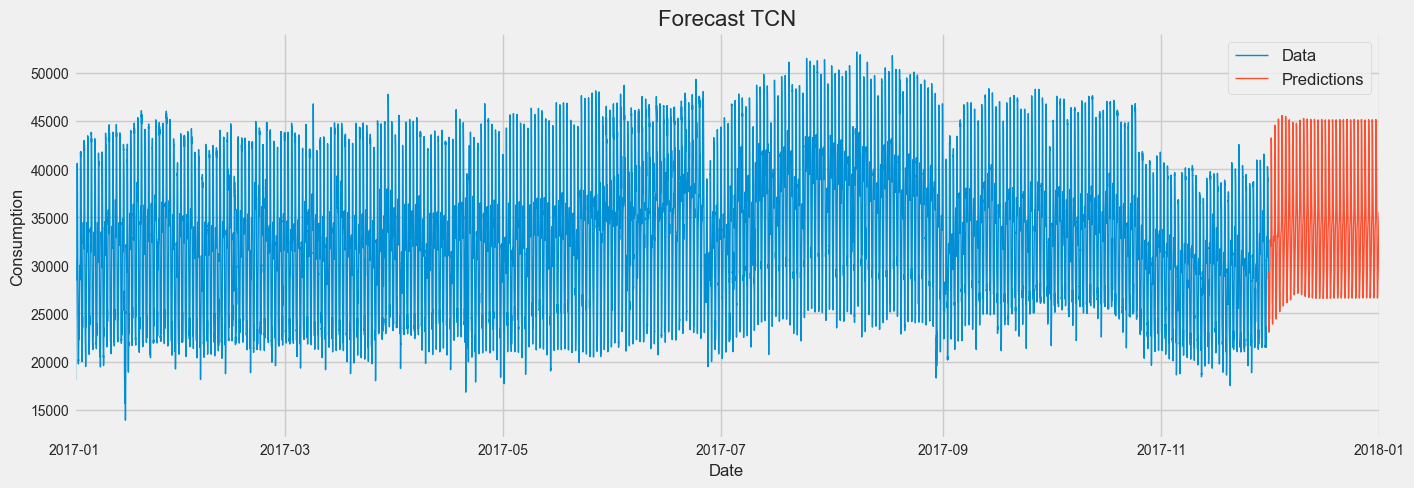

In [7]:
# Plot data and predictions
plt.figure(figsize=(15,5))
plt.plot(df["y"], lw=1, label="Data")
plt.plot(tcn, lw=1, label="Predictions")
# Add the grid to the plot
plt.grid(b=True)
plt.ylabel('Consumption', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title("Forecast TCN", fontsize=16)
plt.xlim(pd.to_datetime("2017-1-1"), pd.to_datetime("2018-1-1"))
# Remove top and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Reduce ticks fontsize
plt.tick_params(axis='both', which='major', labelsize=10)
# Add legend, fontsize 12
plt.legend(loc='upper right', fontsize=12)
# Save the plot
plt.savefig("tcn.png", bbox_inches='tight')
plt.show()

In [8]:
# Now take arima.csv, tcn.csv and ucm.csv and create a new dataframe with the predictions of the three models

# Read the csv files
arima = pd.read_csv("arima.csv", index_col=0, parse_dates=True)
ml = pd.read_csv("ML.csv", index_col=0, parse_dates=True)
ucm = pd.read_csv("ucm.csv", index_col=0, parse_dates=True)


In [12]:
export = pd.concat([arima, ml, ucm], axis=1)

In [14]:
# Change the order of the columns
export = export[["ARIMA","UCM","ML"]]

In [16]:
export.to_csv("843283_20230201.csv", header=True)